# 💃DanceTrack MOT Project
---
Jana Nikolovska \
Project work for Machine Learning for Computer Vision \
University of Bologna

---
Notebook pipeline:
- Load DanceTrack split
- Run tracking-by-detection baselines:
  - **B0** IoU-only
  - **B1** ByteTrack-style
  - **B2** B1 + gated ReID (optimized)
- Export MOT-format results
- Evaluation (motmetrics)



## 🔧 Notebook Setup: Imports, Constants

In [1]:
!pip -q install ultralytics motmetrics scipy

In [2]:
import gc
import json
import math
import os
import random
import sys
import time
from collections import OrderedDict, defaultdict
from pathlib import Path

import numpy as np
import pandas as pd
from PIL import Image
from scipy.optimize import linear_sum_assignment

import matplotlib.pyplot as plt
import matplotlib.patches as patches

import torch
import torch.nn as nn
import torch.nn.functional as F

import torchvision
import torchvision.transforms.functional as TF
from torchvision.io import read_image
from torchvision.ops import nms, roi_align

import motmetrics as mm

from ultralytics import YOLO


print(f"torch: {torch.__version__}")
print(f"torchvision: {torchvision.__version__}")
cuda_ok = torch.cuda.is_available()
print(f"cuda available: {cuda_ok}")
if cuda_ok:
    print(f"gpu: {torch.cuda.get_device_name(0)}")

DEVICE = "cuda" if cuda_ok else "cpu"


torch: 2.9.0+cu128
torchvision: 0.24.0+cu128
cuda available: True
gpu: NVIDIA A100-SXM4-40GB


In [3]:
try:
    from google.colab import drive
    drive.mount('/content/drive')
    IN_COLAB = True
except Exception:
    IN_COLAB = False
    print("Not running in Colab (or drive mount failed). Continuing...")

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [4]:
DRIVE_BASE_DIR = Path("/content/drive/MyDrive/DANCE")

SPLIT = "train"
SPLIT_DIR = DRIVE_BASE_DIR / SPLIT

OUT_BASE = Path("/content/drive/MyDrive/DANCE/results") / f"{SPLIT}_runs"

YOLO_ONLY_DIR = Path("/content/drive/MyDrive/DANCE/results") / "outputs/YOLO_ONLY"

MAX_FRAMES = 1000 #limit frame number for initial runs and debugging (None = full)
LOAD_IF_AVAILABLE = True #skip re-executing the models if they are presaved in DRIVE_BASE_DIR
SAVE_YOLO_DETECTIONS = False #save/overwrite yolo only detections

_IMAGENET_MEAN = torch.tensor([0.485, 0.456, 0.406]).view(1,3,1,1)
_IMAGENET_STD  = torch.tensor([0.229, 0.224, 0.225]).view(1,3,1,1)

SEED = 42
random.seed(SEED); np.random.seed(SEED); torch.manual_seed(SEED)

print("SPLIT:", SPLIT)
print("SPLIT_DIR:", SPLIT_DIR)
print("OUT_BASE:", OUT_BASE)
print("MAX_FRAMES:", MAX_FRAMES)

SPLIT: train
SPLIT_DIR: /content/drive/MyDrive/DANCE/train
OUT_BASE: /content/drive/MyDrive/DANCE/results/train_runs
MAX_FRAMES: 1000


In [5]:
def resolve_split_dir(split_dir: Path) -> Path:
    """Validate and return an existing dataset split directory."""
    split_dir = Path(split_dir)
    if not split_dir.exists():
        raise FileNotFoundError(f"Split dir not found: {split_dir}")
    return split_dir

def list_sequences(split_dir: Path):
    """List all dancetrack* sequence names under a dataset split directory."""
    split_dir = Path(split_dir)
    return sorted([p.name for p in split_dir.iterdir() if p.is_dir() and p.name.startswith("dancetrack")])


SPLIT_DIR_RESOLVED = resolve_split_dir(SPLIT_DIR)
seqs = list_sequences(SPLIT_DIR_RESOLVED)#[:3] Add if you want to limit number of sequences
print("Resolved split dir:", SPLIT_DIR_RESOLVED)
print("Num sequences:", len(seqs))
print("First 10 sequences:", seqs)

Resolved split dir: /content/drive/MyDrive/DANCE/train
Num sequences: 40
First 10 sequences: ['dancetrack0001', 'dancetrack0002', 'dancetrack0006', 'dancetrack0008', 'dancetrack0012', 'dancetrack0015', 'dancetrack0016', 'dancetrack0020', 'dancetrack0023', 'dancetrack0024', 'dancetrack0027', 'dancetrack0029', 'dancetrack0032', 'dancetrack0033', 'dancetrack0037', 'dancetrack0039', 'dancetrack0044', 'dancetrack0045', 'dancetrack0049', 'dancetrack0051', 'dancetrack0052', 'dancetrack0053', 'dancetrack0055', 'dancetrack0057', 'dancetrack0061', 'dancetrack0062', 'dancetrack0066', 'dancetrack0068', 'dancetrack0069', 'dancetrack0072', 'dancetrack0074', 'dancetrack0075', 'dancetrack0080', 'dancetrack0082', 'dancetrack0083', 'dancetrack0086', 'dancetrack0087', 'dancetrack0096', 'dancetrack0098', 'dancetrack0099']


## 📊 Dataset Overview



In [6]:
def iter_sequence(ds_full, seq_name):
    """Yield (frame_id, img, target) for seq_name in chronological order using the dataset's precomputed index."""
    yield from ds_full.iter_sequence(seq_name)

def get_seq_indices(ds_full, seq_name):
    """Return dataset indices for seq_name in chronological order (precomputed in ds_full.seq_to_indices)."""
    return list(ds_full.seq_to_indices.get(seq_name, []))

class DanceTrackFrameDataset(torch.utils.data.Dataset):
    """
    Fast-ish dataset for DanceTrack in Colab.

    Key changes vs your current version:
      1) PRECOMPUTE targets ONCE in __init__ (no per-frame tensor building)
      2) Optional LRU cache for decoded images (helps if you revisit frames)
      3) Still returns uint8 CHW by default (same as your current pipeline)
    """

    def __init__(
        self,
        split_dir,
        transform=None,
        image_ext=".jpg",
        cache_images_lru=0,   # 0 disables; try 128/256 if you revisit frames
    ):
        self.split_dir = Path(split_dir)
        assert self.split_dir.exists(), f"Split dir not found: {self.split_dir}"
        self.transform = transform
        self.image_ext = image_ext

        self.seqs = sorted([p for p in self.split_dir.iterdir()
                            if p.is_dir() and p.name.startswith("dancetrack")])
        assert len(self.seqs) > 0, f"No sequences found under: {self.split_dir}"

        self.samples = []  # list[(seq_name, frame_path, frame_id)]
        self.index_by_seq_frame = {}
        self.seq_to_indices = defaultdict(list)

        # --- LRU cache for images (decoded uint8 tensors)
        self.cache_images_lru = int(cache_images_lru) if cache_images_lru else 0
        self._img_cache = OrderedDict()  # key=(seq, frame_id) -> img_u8

        # --- Load GT and PRECOMPUTE targets once
        self.gt_by_seq = {}
        self.target_cache = {}  # key=(seq_name, frame_id) -> target dict with tensors

        for seq_dir in self.seqs:
            seq_name = seq_dir.name
            img_dir = seq_dir / "img1"
            gt_path = seq_dir / "gt" / "gt.txt"
            assert img_dir.exists(), f"Missing img1: {img_dir}"
            assert gt_path.exists(), f"Missing gt.txt: {gt_path}"

            gt = parse_mot_txt(gt_path, is_gt=True)
            self.gt_by_seq[seq_name] = gt

            # Index frames
            frame_paths = sorted(img_dir.glob(f"*{self.image_ext}"))
            for fp in frame_paths:
                try:
                    frame_id = int(fp.stem)
                except Exception:
                    continue
                self.samples.append((seq_name, fp, frame_id))

        # Global sort once
        self.samples.sort(key=lambda x: (x[0], x[2]))

        # Build lookup indexes and precompute targets once
        for idx, (seq_name, fp, frame_id) in enumerate(self.samples):
            self.index_by_seq_frame[(seq_name, frame_id)] = fp
            self.seq_to_indices[seq_name].append(idx)

            gt_list = self.gt_by_seq[seq_name].get(frame_id, [])
            if len(gt_list) == 0:
                boxes = torch.zeros((0, 4), dtype=torch.float32)
                track_ids = torch.zeros((0,), dtype=torch.int64)
            else:
                # Build tensors ONCE here
                boxes = torch.tensor([list(ann["xyxy"]) for ann in gt_list], dtype=torch.float32)
                track_ids = torch.tensor([int(ann["id"]) for ann in gt_list], dtype=torch.int64)

            self.target_cache[(seq_name, frame_id)] = {
                "boxes": boxes,
                "track_ids": track_ids,
                "frame_id": torch.tensor(frame_id, dtype=torch.int64),
                "seq_name": seq_name,
            }

        print(f"[DanceTrackFrameDataset] samples={len(self.samples)} sequences={len(self.seqs)}")
        if self.cache_images_lru > 0:
            print(f"[DanceTrackFrameDataset] image LRU cache enabled: {self.cache_images_lru} frames")

    def __len__(self):
        return len(self.samples)

    @staticmethod
    def _load_image_u8(fp: Path):
        """
        Load image from disk -> CHW uint8.
        (Drive is slow; staging to /content is the real win.)
        """
        img_chw = read_image(str(fp))  # uint8, CHW
        if img_chw.shape[0] == 1:
            img_chw = img_chw.repeat(3, 1, 1)
        elif img_chw.shape[0] == 4:
            img_chw = img_chw[:3]
        return img_chw

    def _get_cached_image(self, seq_name: str, frame_id: int, frame_path: Path):
        key = (seq_name, frame_id)

        if self.cache_images_lru > 0:
            hit = self._img_cache.get(key, None)
            if hit is not None:
                # refresh LRU order
                self._img_cache.move_to_end(key)
                return hit

        img_u8 = self._load_image_u8(frame_path)

        if self.cache_images_lru > 0:
            self._img_cache[key] = img_u8
            self._img_cache.move_to_end(key)
            # evict oldest
            while len(self._img_cache) > self.cache_images_lru:
                self._img_cache.popitem(last=False)

        return img_u8

    def __getitem__(self, idx):
        seq_name, frame_path, frame_id = self.samples[idx]

        img_u8 = self._get_cached_image(seq_name, frame_id, frame_path)

        target = self.target_cache[(seq_name, frame_id)]

        if self.transform is not None:
            img_u8, target = self.transform(img_u8, target)

        return img_u8, target

    def get_frame(self, seq_name, frame_id):
        key = (seq_name, int(frame_id))
        fp = self.index_by_seq_frame.get(key)
        if fp is None:
            raise KeyError(f"Frame {frame_id} not found for seq {seq_name}")

        img_u8 = self._get_cached_image(seq_name, int(frame_id), fp)
        return img_u8, fp.name

    def iter_sequence(self, seq_name):
        for i in self.seq_to_indices.get(seq_name, []):
            img, tgt = self[i]
            yield int(tgt["frame_id"]), img, tgt


In [7]:
SPLIT_DIR = "/content/dancetrack_staged/train"

## 🧩 Pipeline Implementation

### 📦Utility Functions

In [8]:
# Box Utils
def xyxy_to_xywh(boxes_xyxy):
    b = np.asarray(boxes_xyxy, dtype=np.float32)

    if b.size == 0:
        return np.zeros((0,4), dtype=np.float32)

    # single box shape (4,)
    if b.ndim == 1:
        x1, y1, x2, y2 = b
        return np.array([x1, y1, x2 - x1, y2 - y1], dtype=np.float32)

    # batch shape (N,4)
    x1, y1, x2, y2 = b[:,0], b[:,1], b[:,2], b[:,3]
    return np.stack([x1, y1, x2 - x1, y2 - y1], axis=1).astype(np.float32)


# # def iou_xyxy(a, b):
# #     return box_iou_xyxy(np.asarray(a)[None], np.asarray(b)[None])[0, 0]

def xywh_to_xyxy(boxes_xywh):
    """
    Convert boxes from (x, y, w, h) to (x1, y1, x2, y2).

    Args:
        boxes_xywh: array-like of shape (N, 4)
                    where each box is (x, y, w, h)

    Returns:
        boxes_xyxy: np.ndarray of shape (N, 4)
                    where each box is (x1, y1, x2, y2)
    """
    if boxes_xywh is None or len(boxes_xywh) == 0:
        return np.zeros((0, 4), dtype=np.float32)

    boxes_xywh = np.asarray(boxes_xywh, dtype=np.float32)

    x = boxes_xywh[:, 0]
    y = boxes_xywh[:, 1]
    w = boxes_xywh[:, 2]
    h = boxes_xywh[:, 3]

    x1 = x
    y1 = y
    x2 = x + w
    y2 = y + h

    return np.stack([x1, y1, x2, y2], axis=1)

def iou_xywh(a, b):
    ax, ay, aw, ah = a
    bx, by, bw, bh = b

    ax2, ay2 = ax + aw, ay + ah
    bx2, by2 = bx + bw, by + bh

    ix1, iy1 = max(ax, bx), max(ay, by)
    ix2, iy2 = min(ax2, bx2), min(ay2, by2)

    iw = max(0.0, ix2 - ix1)
    ih = max(0.0, iy2 - iy1)
    inter = iw * ih

    area_a = max(0.0, aw) * max(0.0, ah)
    area_b = max(0.0, bw) * max(0.0, bh)
    union = area_a + area_b - inter + 1e-12
    return inter / union

def box_iou_xyxy(a, b):
    a = np.asarray(a, dtype=np.float32)
    b = np.asarray(b, dtype=np.float32)
    if a.size == 0 or b.size == 0:
        return np.zeros((a.shape[0], b.shape[0]), dtype=np.float32)

    ax1, ay1, ax2, ay2 = a[:,0:1], a[:,1:2], a[:,2:3], a[:,3:4]
    bx1, by1, bx2, by2 = b[:,0], b[:,1], b[:,2], b[:,3]

    inter_x1 = np.maximum(ax1, bx1)
    inter_y1 = np.maximum(ay1, by1)
    inter_x2 = np.minimum(ax2, bx2)
    inter_y2 = np.minimum(ay2, by2)
    inter_w = np.maximum(0.0, inter_x2 - inter_x1)
    inter_h = np.maximum(0.0, inter_y2 - inter_y1)
    inter = inter_w * inter_h

    area_a = np.maximum(0.0, ax2-ax1) * np.maximum(0.0, ay2-ay1)
    area_b = np.maximum(0.0, bx2-bx1) * np.maximum(0.0, by2-by1)
    union = area_a + area_b - inter + 1e-6
    return (inter / union).astype(np.float32)

def get_xyxy(item):
    """Return np.array([x1,y1,x2,y2]) regardless of whether item stores 'xyxy' or 'box' (xywh)."""
    if "xyxy" in item:
        return np.asarray(item["xyxy"], dtype=np.float32)
    if "box" in item:
        x, y, w, h = item["box"]
        return np.asarray([x, y, x + w, y + h], dtype=np.float32)
    raise KeyError(f"Missing box keys. Has: {list(item.keys())}")


def get_xywh(item):
    """Return [x,y,w,h] no matter if item stores 'box' (xywh) or 'xyxy'."""
    if "box" in item:
        x, y, w, h = item["box"]
        return [float(x), float(y), float(w), float(h)]
    if "xyxy" in item:
        x1, y1, x2, y2 = item["xyxy"]
        return [float(x1), float(y1), float(x2 - x1), float(y2 - y1)]
    raise KeyError(f"Missing box keys. Has: {list(item.keys())}")

def hungarian_match_frame(gt_list, pr_list, iou_thresh=0.5):
    """
    Optimal (Hungarian) matching on IoU for one frame.
      matches: list[(gi, pi, iou)]
      um_g: unmatched gt indices
      um_p: unmatched pred indices
    """
    if len(gt_list) == 0 or len(pr_list) == 0:
        return [], list(range(len(gt_list))), list(range(len(pr_list)))

    gt_xyxy = np.asarray([get_xyxy(g) for g in gt_list], dtype=np.float32)
    pr_xyxy = np.asarray([get_xyxy(p) for p in pr_list], dtype=np.float32)

    iou_mat = box_iou_xyxy(gt_xyxy, pr_xyxy)  # (G,P)

    # maximize IoU -> minimize (1 - IoU)
    cost = 1.0 - iou_mat
    rows, cols = linear_sum_assignment(cost)

    matches = []
    matched_g = set()
    matched_p = set()

    for gi, pi in zip(rows, cols):
        iou = float(iou_mat[gi, pi])
        if iou >= iou_thresh:
            matches.append((int(gi), int(pi), iou))
            matched_g.add(int(gi))
            matched_p.add(int(pi))

    um_g = [i for i in range(len(gt_list)) if i not in matched_g]
    um_p = [i for i in range(len(pr_list)) if i not in matched_p]
    return matches, um_g, um_p



def greedy_match_frame(gt_list, pr_list, iou_thresh=0.5):
    """
    Greedy bipartite matching on IoU for one frame.
    Items can store either:
      - item["box"] = [x,y,w,h]  OR
      - item["xyxy"] = (x1,y1,x2,y2)
    Returns:
      matches: list[(gi, pi, iou)]
      um_g: unmatched gt indices
      um_p: unmatched pred indices
    """
    if len(gt_list) == 0 or len(pr_list) == 0:
        return [], list(range(len(gt_list))), list(range(len(pr_list)))

    gt_xyxy = np.asarray([get_xyxy(g) for g in gt_list], dtype=np.float32)
    pr_xyxy = np.asarray([get_xyxy(p) for p in pr_list], dtype=np.float32)

    iou_mat = box_iou_xyxy(gt_xyxy, pr_xyxy)  # (N,M)
    matches, um_g, um_p = greedy_match(iou_mat, iou_thresh=iou_thresh)
    return matches, um_g, um_p

In [9]:
#Track Utils
def init_track(track_id, box_xyxy, frame_id):
    return {"track_id": int(track_id),
            "box_xyxy": np.asarray(box_xyxy, dtype=np.float32),
            "last_frame": int(frame_id),
            "age": 0, "hits": 1, "confirmed": False,
            "emb": None}

def gather_track_boxes(tracks):
    if len(tracks) == 0:
        return np.zeros((0,4), dtype=np.float32)
    return np.stack([t["box_xyxy"] for t in tracks], axis=0).astype(np.float32)

def subset_tracks(tracks, idxs):
    return [tracks[i] for i in idxs]

def greedy_match(iou_mat, iou_thresh, verbose=False):
    if iou_mat.size == 0:
        return [], list(range(iou_mat.shape[0])), list(range(iou_mat.shape[1]))
    N, M = iou_mat.shape
    flat = [(r,c,float(iou_mat[r,c])) for r in range(N) for c in range(M)]
    flat.sort(key=lambda x: x[2], reverse=True)
    used_r, used_c = set(), set()
    matches = []
    for r,c,v in flat:
        if v < iou_thresh:
            break
        if r in used_r or c in used_c:
            continue
        used_r.add(r); used_c.add(c)
        matches.append((r,c,v))
    unmatched_r = [r for r in range(N) if r not in used_r]
    unmatched_c = [c for c in range(M) if c not in used_c]
    return matches, unmatched_r, unmatched_c

def split_detections_by_score(det_boxes, det_scores, high_thresh=0.6, low_thresh=0.1):
    det_boxes = np.asarray(det_boxes, dtype=np.float32)
    det_scores = np.asarray(det_scores, dtype=np.float32)
    high_mask = det_scores >= high_thresh
    low_mask  = (det_scores >= low_thresh) & (det_scores < high_thresh)
    high_idx = np.where(high_mask)[0].tolist()
    low_idx  = np.where(low_mask)[0].tolist()
    return (det_boxes[high_mask], det_scores[high_mask], high_idx), (det_boxes[low_mask], det_scores[low_mask], low_idx)

def update_tracks_with_matches(tracks, det_boxes, matches, frame_id, min_hits, det_assigned_ids, det_global_idx_map):
    for ti, di, _ in matches:
        t = tracks[ti]
        t["box_xyxy"] = det_boxes[di].astype(np.float32)
        t["last_frame"] = int(frame_id)
        t["age"] = 0
        t["hits"] += 1
        if t["hits"] >= min_hits:
            t["confirmed"] = True
        gdi = det_global_idx_map[di]
        det_assigned_ids[gdi] = t["track_id"]

In [10]:
# Visualization Utils
def _to_np_img(img_chw):
    x = img_chw.detach().cpu().permute(1, 2, 0).numpy()
    if x.dtype == np.uint8:
        x = x.astype(np.float32) / 255.0
    return np.clip(x, 0.0, 1.0)


def _as_np(a):
    if a is None:
        return None
    if hasattr(a, "detach"):
        return a.detach().cpu().numpy()
    return np.asarray(a)

def draw_boxes_xyxy(ax, boxes_xyxy, color="lime", alpha=0.25, lw=2, labels=None, label_color="black"):
    boxes_xyxy = _as_np(boxes_xyxy)
    if boxes_xyxy is None or len(boxes_xyxy) == 0:
        return
    for i, b in enumerate(boxes_xyxy):
        x1, y1, x2, y2 = map(float, b)
        w, h = max(0.0, x2 - x1), max(0.0, y2 - y1)
        rect = patches.Rectangle((x1, y1), w, h, linewidth=lw, edgecolor=color,
                                 facecolor=color, alpha=alpha)
        ax.add_patch(rect)
        if labels is not None:
            s = str(labels[i])
            ax.text(x1, y1, s, fontsize=7, color=label_color,
                    bbox=dict(facecolor="white", alpha=0.6, pad=1, edgecolor="none"))

def _get_det_for_frame(det_fn, frame_id, img, tgt, conf_show=0.0, show_scores=True):
    """Run det_fn and return (boxes, labels, n_kept) after score filtering."""
    boxes, scores = det_fn(frame_id, img, tgt, verbose=False)
    boxes = np.asarray(boxes, np.float32)
    scores = np.asarray(scores, np.float32)

    if boxes.shape[0] == 0:
        return boxes, None, 0

    keep = scores >= float(conf_show)
    boxes = boxes[keep]
    scores = scores[keep]

    labels = None
    if show_scores:
        labels = [f"{s:.2f}" for s in scores.tolist()]
    return boxes, labels, int(boxes.shape[0])


def _draw_gt_and_det(ax, img, tgt, det_fn=None, conf_show=0.0, show_gt=True, show_det=True, show_scores=False):
    """Draw image + optional GT and detections on a matplotlib axis."""
    img_np = _to_np_img(img)
    ax.imshow(img_np)
    ax.axis("off")

    # GT
    if show_gt and tgt is not None and "boxes" in tgt:
        gt_labels = None
        if "track_ids" in tgt:
            gt_labels = [str(int(x)) for x in _as_np(tgt["track_ids"]).tolist()]
        draw_boxes_xyxy(ax, tgt["boxes"], color="lime", alpha=0.20, lw=2, labels=gt_labels, label_color="black")

    # DET
    det_count = None
    if show_det and det_fn is not None:
        frame_id = int(tgt["frame_id"]) if (tgt is not None and "frame_id" in tgt) else None
        if frame_id is None:
            return det_count  # can't run dets safely

        boxes, det_labels, det_count = _get_det_for_frame(
            det_fn, frame_id, img, tgt, conf_show=conf_show, show_scores=show_scores
        )
        if det_count > 0:
            draw_boxes_xyxy(ax, boxes, color="red", alpha=0.18, lw=2, labels=det_labels, label_color="black")

    return det_count

def _show_frames(
    ds_full,
    seq_name,
    frame_indices,
    grid_r,
    grid_c,
    det_fn=None,
    conf_show=0.25,
    show_gt=True,
    show_det=True,
    show_scores=False,
    figsize=None,
    suptitle=None,
):
    """Internal core renderer used by both single-frame and grid visualizations."""
    idxs = get_seq_indices(ds_full, seq_name)
    assert len(idxs) > 0, f"No frames for seq={seq_name}"

    frame_indices = [int(np.clip(i, 0, len(idxs) - 1)) for i in frame_indices]
    ds_pick = [idxs[i] for i in frame_indices]
    n = len(ds_pick)

    if figsize is None:
        figsize = (4 * grid_c, 3.2 * grid_r)

    fig, axes = plt.subplots(grid_r, grid_c, figsize=figsize)
    axes = np.asarray(axes).reshape(grid_r, grid_c)

    total_dets = 0

    for k, ax in enumerate(axes.flat):
        if k >= n:
            ax.axis("off")
            continue

        img, tgt = ds_full[ds_pick[k]]
        det_count = _draw_gt_and_det(
            ax, img, tgt,
            det_fn=det_fn,
            conf_show=conf_show,
            show_gt=show_gt,
            show_det=show_det,
            show_scores=show_scores,
        )

        fid = int(tgt["frame_id"]) if (tgt is not None and "frame_id" in tgt) else frame_indices[k]
        ax.set_title(f"frame {fid}", fontsize=8)

        if det_count is not None:
            total_dets += det_count

    if suptitle is None:
        suptitle = (grid_r * grid_c > 1)

    if suptitle:
        fig.suptitle(
            f"{seq_name} | conf_show>={conf_show} | dets_shown={total_dets if show_det and det_fn else 'N/A'}",
            fontsize=12
        )

    plt.tight_layout()
    plt.show()

def show_frame_gt_vs_yolo(
    ds_full,
    seq_name,
    frame_index=0,
    det_fn=None,
    conf_show=0.0,
    show_gt=True,
    show_det=True,
    show_scores=True,
    figsize=(10, 6),
):
    """Visualize one frame with GT and detector boxes overlaid."""
    _show_frames(
        ds_full=ds_full,
        seq_name=seq_name,
        frame_indices=[frame_index],
        grid_r=1,
        grid_c=1,
        det_fn=det_fn,
        conf_show=conf_show,
        show_gt=show_gt,
        show_det=show_det,
        show_scores=show_scores,
        figsize=figsize,
        suptitle=False,
    )
def show_sequence_grid_gt_vs_yolo(
    ds_full,
    seq_name,
    start_frame_index=0,
    grid=4,
    det_fn=None,
    conf_show=0.25,
    show_gt=True,
    show_det=True,
    show_scores=False,
    figsize=None
):
    """Visualize a grid of consecutive frames with GT and detector boxes overlaid."""
    n = int(grid) * int(grid)
    frame_indices = list(range(int(start_frame_index), int(start_frame_index) + n))

    _show_frames(
        ds_full=ds_full,
        seq_name=seq_name,
        frame_indices=frame_indices,
        grid_r=int(grid),
        grid_c=int(grid),
        det_fn=det_fn,
        conf_show=conf_show,
        show_gt=show_gt,
        show_det=show_det,
        show_scores=show_scores,
        figsize=figsize,
        suptitle=True,
    )



In [11]:
# Exporting results, file manipulation

def parse_mot_txt(path, is_gt: bool = False, keep_id0: bool = True):
    """Parse MOT txt into frame_id -> list[{id, xyxy, score, cls, vis}] with optional GT filtering."""
    frame_dict = defaultdict(list)
    path = Path(path)

    with path.open("r") as f:
        for line in f:
            line = line.strip()
            if not line or line.startswith("#"):
                continue
            parts = line.split(",")
            if len(parts) < 6:
                continue

            frame = int(float(parts[0]))
            tid   = int(float(parts[1]))
            x, y, w, h = map(float, parts[2:6])

            mark = float(parts[6]) if len(parts) >= 7 else 1.0
            cls  = int(float(parts[7])) if len(parts) >= 8 else -1
            vis  = float(parts[8]) if len(parts) >= 9 else -1.0

            if is_gt:
                if mark < 1.0:
                    continue
                if (tid <= 0) and (not keep_id0):
                    continue

            frame_dict[frame].append({
                "id": tid,
                "xyxy": (x, y, x + w, y + h),
                "score": mark,
                "cls": cls,
                "vis": vis,
            })

    return frame_dict

def load_mot(txt_path, score_thresh=0.0, as_frames_dict=False):
    """
    Load a MOT txt file as either:
      - list of rows: (frame, tid, x, y, w, h, score)
      - OR dict[frame] -> list[{id, box(xywh), score}] if as_frames_dict=True
    """
    rows = list(iter_mot_rows(txt_path, score_thresh=score_thresh))
    if not as_frames_dict:
        return rows

    frames = defaultdict(list)
    for frame, tid, x, y, w, h, score in rows:
        frames[frame].append({"id": tid, "box": [x, y, w, h], "score": score})
    return dict(frames)

def iter_mot_rows(txt_path, score_thresh=0.0):
    """
    Yields MOT rows as tuples:
      (frame, tid, x, y, w, h, score)

    Accepts lines like:
      frame,tid,x,y,w,h,score,-1,-1,-1
    """
    txt_path = Path(txt_path)
    with txt_path.open("r") as f:
        for line in f:
            line = line.strip()
            if not line:
                continue

            parts = line.split(",")
            if len(parts) < 6:
                continue

            frame = int(float(parts[0]))
            tid   = int(float(parts[1]))
            x, y, w, h = map(float, parts[2:6])
            score = float(parts[6]) if len(parts) > 6 else 1.0

            if score < score_thresh:
                continue

            yield (frame, tid, x, y, w, h, score)


def write_mot_results_file(mot_rows, out_txt_path, verbose=False):
    out_txt_path = Path(out_txt_path)
    out_dir = out_txt_path.parent

    if verbose:
        print(f"[MOT] Preparing to write results...")
        print(f"[MOT] Output directory: {out_dir.resolve()}")

    # Create directory if needed
    out_dir.mkdir(parents=True, exist_ok=True)

    if out_txt_path.exists():
        if verbose:
            print(f"[MOT] Warning: file already exists and will be overwritten:")
            print(f"      {out_txt_path.resolve()}")

    # Sort rows by frame, then track id
    mot_rows = sorted(mot_rows, key=lambda r: (int(r[0]), int(r[1])))

    if verbose:
        print(f"[MOT] Writing {len(mot_rows)} MOT rows to file...")

    with open(out_txt_path, "w") as f:
        for r in mot_rows:
            frame, tid = int(r[0]), int(r[1])
            x, y, w, h = map(float, r[2:6])
            score = float(r[6]) if len(r) > 6 else 1.0
            f.write(
                f"{frame},{tid},{x:.3f},{y:.3f},{w:.3f},{h:.3f},{score:.6f},-1,-1,-1\n"
            )

    if verbose:
        print(f"[MOT] Results successfully written.")
        print(f"[MOT] File path: {out_txt_path.resolve()}")




### 🎯 Object Detector Implementation

In [12]:
def load_yolo_ultralytics(model_name="yolov8n.pt", device="cuda", verbose=True):
    model = YOLO(model_name)
    if verbose:
        print(f"[load_yolo_ultralytics] loaded {model_name}")
    return model

# import numpy as np
# import torch
# import time

def make_det_fn_yolo_ultralytics(
    yolo_model,
    device="cuda:0",
    person_only=True,
    conf=0.25,
    iou=0.6,
    max_det=300,
    imgsz=640,
    half=True,
    verbose=False,
):
    PERSON_CLS = 0

    if verbose:
        print(
            "[YOLO det_fn U8] init | "
            f"device={device} imgsz={imgsz} conf={conf} iou={iou} "
            f"half={half} person_only={person_only}"
        )

    @torch.no_grad()
    def det_fn(frame_id, img_u8_chw, target=None, verbose_inner=False, **kwargs):
        """
        img_u8_chw: torch.uint8 [3,H,W] on CPU (0..255)
        returns: boxes_xyxy (Nx4), scores (N,)
        """
        t0 = time.perf_counter()

        # CHW uint8 -> HWC uint8 numpy (cheap)
        if not torch.is_tensor(img_u8_chw):
            raise TypeError("Expected torch.uint8 tensor from dataset.")
        if img_u8_chw.dtype != torch.uint8:
            raise TypeError(f"Expected uint8 image, got {img_u8_chw.dtype}")

        img_hwc = img_u8_chw.permute(1, 2, 0).contiguous().numpy()

        t1 = time.perf_counter()

        res = yolo_model.predict(
            source=img_hwc,
            device=device,
            imgsz=imgsz,
            conf=conf,
            iou=iou,
            max_det=max_det,
            half=half,
            verbose=False
        )[0]

        t2 = time.perf_counter()

        if res.boxes is None or len(res.boxes) == 0:
            if verbose_inner:
                print(f"[YOLO det U8] frame={frame_id} dets=0 | prep={(t1-t0)*1e3:.1f}ms fwd={(t2-t1)*1e3:.1f}ms")
            return np.zeros((0,4), np.float32), np.zeros((0,), np.float32)

        boxes = res.boxes.xyxy.detach().cpu().numpy().astype(np.float32)
        scores = res.boxes.conf.detach().cpu().numpy().astype(np.float32)
        cls    = res.boxes.cls.detach().cpu().numpy().astype(np.int32)

        if person_only:
            keep = (cls == PERSON_CLS)
            boxes = boxes[keep]
            scores = scores[keep]

        t3 = time.perf_counter()

        if verbose_inner:
            print(
                f"[YOLO det U8] frame={frame_id} dets={len(boxes)} | "
                f"prep={(t1-t0)*1e3:.1f}ms fwd={(t2-t1)*1e3:.1f}ms post={(t3-t2)*1e3:.1f}ms"
            )

        return boxes, scores

    return det_fn

@torch.no_grad()
def export_yolo_detections_mot_robust(
    ds_full,
    seq_names,
    det_fn,
    out_dir,
    conf_save=0.001,
    overwrite=False,
    verbose=True,
    log_filename="det_export_log.txt",
    save_json_summary=True,
    max_frames=None,

    # progress / diagnostics
    progress_every=50,         # print every N frames
    diag_window=50,            # avg dets + avg times over last N frames
    cleanup_every=400,         # run gc/empty_cache every N frames (0 disables)

    # failure protection
    min_fps_abort=2.0,         # if window fps falls below this -> abort sequence (None disables)
    abort_after_windows=2,     # how many bad windows before abort
):
    """
    Robust YOLO detection export to MOT format with:
      - progress prints
      - split timing: dataset load vs det_fn time
      - periodic cleanup
      - safety abort if FPS collapses (to avoid wasting resources)
      - logs to text file + optional json summary
    """
    out_dir = Path(out_dir)
    out_dir.mkdir(parents=True, exist_ok=True)

    log_path = out_dir / log_filename
    log_lines = []
    summary = {"per_seq": [], "overall": {}}

    def log(msg):
        if verbose:
            print(msg)
        log_lines.append(msg + "\n")

    # ----------------------------
    # Header
    # ----------------------------
    log(f"[YOLO export] out_dir={out_dir.resolve()}")
    log(f"[YOLO export] conf_save={conf_save} | overwrite={overwrite} | max_frames={max_frames}")
    log(f"[YOLO export] progress_every={progress_every} | diag_window={diag_window} | cleanup_every={cleanup_every}")
    log(f"[YOLO export] min_fps_abort={min_fps_abort} | abort_after_windows={abort_after_windows}")
    log(f"[YOLO export] torch.cuda.is_available()={torch.cuda.is_available()}")
    if torch.cuda.is_available():
        try:
            log(f"[YOLO export] GPU={torch.cuda.get_device_name(0)}")
        except Exception:
            pass
    log("")

    total_time = 0.0
    total_frames = 0
    total_dets = 0

    for seq_i, seq in enumerate(seq_names, start=1):
        out_path = out_dir / f"{seq}.txt"

        idxs = get_seq_indices(ds_full, seq)
        if len(idxs) == 0:
            log(f"[{seq_i}/{len(seq_names)}] {seq}: skip (no frames)")
            continue

        if out_path.exists() and not overwrite:
            log(f"[{seq_i}/{len(seq_names)}] {seq}: skip (exists)")
            continue

        n_total = len(idxs)
        if max_frames is not None:
            n_total = min(n_total, int(max_frames))

        log(f"[{seq_i}/{len(seq_names)}] {seq}: start | frames_to_process={n_total}")

        t_seq0 = time.perf_counter()

        lines = []
        det_id_counter = 1
        frames_processed = 0
        dets_written = 0

        # rolling windows for diagnostics
        window_load_times = []
        window_det_times = []
        window_raw_dets = []
        window_t0 = time.perf_counter()
        bad_windows = 0

        aborted = False

        for k, ds_idx in enumerate(idxs):
            if max_frames is not None and k >= int(max_frames):
                break

            # periodic cleanup
            if cleanup_every and k > 0 and (k % int(cleanup_every) == 0):
                if verbose:
                    print(f"[YOLO export] {seq}: cleanup at frame {k}/{n_total} ...")
                gc.collect()
                if torch.cuda.is_available():
                    torch.cuda.empty_cache()

            # ----------------------------
            # Time dataset loading
            # ----------------------------
            t_load0 = time.perf_counter()
            img, tgt = ds_full[ds_idx]
            t_load1 = time.perf_counter()
            load_t = t_load1 - t_load0

            frame_id = int(tgt["frame_id"]) if (tgt is not None and "frame_id" in tgt) else (k + 1)

            # ----------------------------
            # Time detection
            # ----------------------------
            t_det0 = time.perf_counter()
            boxes, scores = det_fn(frame_id, img, tgt, verbose=False)
            t_det1 = time.perf_counter()
            det_t = t_det1 - t_det0

            boxes = np.asarray(boxes, dtype=np.float32)
            scores = np.asarray(scores, dtype=np.float32)

            frames_processed += 1

            raw_n = int(boxes.shape[0]) if boxes is not None else 0

            # update rolling diagnostics
            window_load_times.append(load_t)
            window_det_times.append(det_t)
            window_raw_dets.append(raw_n)
            if len(window_load_times) > int(diag_window):
                window_load_times.pop(0)
                window_det_times.pop(0)
                window_raw_dets.pop(0)

            # ----------------------------
            # Progress / diagnostics prints
            # ----------------------------
            if verbose and progress_every and k > 0 and (k % int(progress_every) == 0):
                elapsed_seq = time.perf_counter() - t_seq0
                pct = 100.0 * k / float(n_total)

                avg_load_ms = 1000.0 * float(np.mean(window_load_times)) if window_load_times else 0.0
                avg_det_ms  = 1000.0 * float(np.mean(window_det_times)) if window_det_times else 0.0
                avg_dets    = float(np.mean(window_raw_dets)) if window_raw_dets else 0.0

                # window fps estimate
                window_elapsed = time.perf_counter() - window_t0
                window_frames = int(progress_every)
                window_fps = (window_frames / window_elapsed) if window_elapsed > 0 else 0.0

                fps_so_far = (frames_processed / elapsed_seq) if elapsed_seq > 0 else 0.0

                print(
                    f"[YOLO export] {seq}: {k}/{n_total} ({pct:.1f}%) | "
                    f"elapsed {elapsed_seq:.1f}s | fps~{fps_so_far:.2f} | "
                    f"WIN_fps~{window_fps:.2f} | "
                    f"avg load={avg_load_ms:.1f}ms | avg det={avg_det_ms:.1f}ms | "
                    f"raw dets this frame={raw_n} | avg raw dets(last {len(window_raw_dets)})={avg_dets:.1f}"
                )

                # abort logic if fps collapses repeatedly
                if min_fps_abort is not None and window_fps < float(min_fps_abort):
                    bad_windows += 1
                    print(f"[WARN] {seq}: window FPS {window_fps:.2f} < {min_fps_abort} (bad_windows={bad_windows})")
                    if bad_windows >= int(abort_after_windows):
                        print(f"[ABORT] {seq}: aborting sequence to avoid wasting resources.")
                        aborted = True
                        break
                else:
                    bad_windows = 0

                # reset window timer
                window_t0 = time.perf_counter()

            # ----------------------------
            # Filter + save detections
            # ----------------------------
            if boxes.shape[0] == 0:
                continue

            keep = scores >= float(conf_save)
            boxes = boxes[keep]
            scores = scores[keep]

            for b, s in zip(boxes, scores):
                x, y, w, h = xyxy_to_xywh(b)
                tid = det_id_counter
                det_id_counter += 1
                lines.append(f"{frame_id},{tid},{x:.2f},{y:.2f},{w:.2f},{h:.2f},{float(s):.6f}\n")
                dets_written += 1

        # If aborted, write partial file (optional) OR skip writing
        if aborted:
            # write partial so you can inspect what happened (comment this out if you don't want partial output)
            out_path.write_text("".join(lines))
            log(f"[{seq_i}/{len(seq_names)}] {seq}: ABORTED after frames={frames_processed} | wrote partial {out_path.name}")
            summary["per_seq"].append({
                "seq": seq,
                "frames": int(frames_processed),
                "seconds": float(time.perf_counter() - t_seq0),
                "fps": float(frames_processed / max(1e-9, (time.perf_counter() - t_seq0))),
                "ms_per_frame": float(1000.0 * (time.perf_counter() - t_seq0) / max(1, frames_processed)),
                "detections": int(dets_written),
                "out_file": str(out_path),
                "aborted": True,
            })
            continue

        # Normal completion: write file once
        out_path.write_text("".join(lines))

        dt = time.perf_counter() - t_seq0
        fps = (frames_processed / dt) if dt > 0 else 0.0
        ms_per_frame = (1000.0 * dt / frames_processed) if frames_processed > 0 else 0.0

        total_time += dt
        total_frames += frames_processed
        total_dets += dets_written

        summary["per_seq"].append({
            "seq": seq,
            "frames": int(frames_processed),
            "seconds": float(dt),
            "fps": float(fps),
            "ms_per_frame": float(ms_per_frame),
            "detections": int(dets_written),
            "out_file": str(out_path),
            "aborted": False,
        })

        log(
            f"[{seq_i}/{len(seq_names)}] {seq}: DONE | frames={frames_processed} | dets={dets_written} | "
            f"time={dt:.2f}s | fps={fps:.2f} | ms/frame={ms_per_frame:.2f} | saved={out_path.name}"
        )

    overall_fps = (total_frames / total_time) if total_time > 0 else 0.0
    overall_ms_per_frame = (1000.0 * total_time / total_frames) if total_frames > 0 else 0.0

    summary["overall"] = {
        "frames": int(total_frames),
        "seconds": float(total_time),
        "fps": float(overall_fps),
        "ms_per_frame": float(overall_ms_per_frame),
        "detections": int(total_dets),
        "out_dir": str(out_dir),
    }

    log("")
    log("=== YOLO EXPORT RUNTIME SUMMARY ===")
    log(f"total_frames={total_frames} | total_dets={total_dets} | total_time={total_time:.2f}s | "
        f"fps={overall_fps:.2f} | ms/frame={overall_ms_per_frame:.2f}")
    log("===================================")

    log_path.write_text("".join(log_lines))
    if verbose:
        print(f"[YOLO export] log written to: {log_path.resolve()}")

    if save_json_summary:
        json_path = out_dir / "det_export_summary.json"
        json_path.write_text(json.dumps(summary, indent=2))
        if verbose:
            print(f"[YOLO export] summary written to: {json_path.resolve()}")

    return summary


def evaluate_detector_from_files(seq_names, gt_root, pred_root, iou_thresh=0.5, matcher="hungarian"):
    if matcher == "hungarian":
        match_fn = hungarian_match_frame
    elif matcher == "greedy":
        match_fn = greedy_match_frame
    else:
        raise ValueError("matcher must be 'hungarian' or 'greedy'")

    per_seq = []
    for seq in seq_names:
        gt_path = Path(gt_root)/seq/"gt"/"gt.txt"
        pr_path = Path(pred_root)/f"{seq}.txt"
        if not gt_path.exists(): raise FileNotFoundError(gt_path)
        if not pr_path.exists(): raise FileNotFoundError(pr_path)

        gt_frames = parse_mot_txt(gt_path, is_gt=True)
        pr_frames = parse_mot_txt(pr_path, is_gt=False)

        all_frames = sorted(set(gt_frames.keys()) | set(pr_frames.keys()))
        FP = FN = MATCHES = 0

        for frame in all_frames:
            gt_list = gt_frames.get(frame, [])
            pr_list = pr_frames.get(frame, [])
            matches, um_g, um_p = match_fn(gt_list, pr_list, iou_thresh=iou_thresh)

            MATCHES += len(matches)
            FN += len(um_g)
            FP += len(um_p)

        precision = MATCHES / (MATCHES + FP + 1e-9)
        recall    = MATCHES / (MATCHES + FN + 1e-9)
        f1        = 2 * precision * recall / (precision + recall + 1e-9)

        per_seq.append({
            "seq": seq,
            "frames": len(all_frames),
            "matches": MATCHES,
            "fp": FP,
            "fn": FN,
            "precision": float(precision),
            "recall": float(recall),
            "f1": float(f1),
            "iou_thresh": float(iou_thresh),
        })

    # global aggregation (correct)
    tot_matches = sum(m["matches"] for m in per_seq)
    tot_fp      = sum(m["fp"] for m in per_seq)
    tot_fn      = sum(m["fn"] for m in per_seq)
    tot_frames  = sum(m["frames"] for m in per_seq)

    precision = tot_matches / (tot_matches + tot_fp + 1e-9)
    recall    = tot_matches / (tot_matches + tot_fn + 1e-9)
    f1        = 2 * precision * recall / (precision + recall + 1e-9)

    overall = {
        "frames": float(tot_frames),
        "matches": float(tot_matches),
        "fp": float(tot_fp),
        "fn": float(tot_fn),
        "precision": float(precision),
        "recall": float(recall),
        "f1": float(f1),
        "iou_thresh": float(iou_thresh),
    }

    return per_seq, overall

def make_det_fn_from_mot(det_root, conf_thresh=0.0, show_scores=False, verbose=True):
    det_root = Path(det_root)

    if verbose:
        print(f"[DET-CACHE] Using cached detections from: {det_root.resolve()}")
        print(f"[DET-CACHE] conf_thresh={conf_thresh}")

    cache = {}  # seq -> frames dict

    def load_seq(seq):
        if seq not in cache:
            det_file = det_root / f"{seq}.txt"
            if verbose:
                print(f"[DET-CACHE] Loading detections for seq='{seq}' from {det_file}")

            if not det_file.exists():
                raise FileNotFoundError(f"Detection file not found: {det_file}")

            frames = load_mot(det_file, score_thresh=conf_thresh, as_frames_dict=True)
            cache[seq] = frames

            if verbose:
                n_frames = len(frames)
                n_dets = sum(len(v) for v in frames.values())
                print(f"[DET-CACHE] Loaded {n_dets} detections over {n_frames} frames for '{seq}'")

        return cache[seq]

    # det_fn compatible: (frame_id, img, tgt, ...) -> (boxes_xyxy, scores)
    def det_fn(frame_id, img, tgt, verbose=False):
        seq = tgt.get("seq_name") if tgt is not None else None
        if seq is None:
            raise ValueError(
                "tgt must contain 'seq_name' to use precomputed detections."
            )

        frames = load_seq(seq)
        dets = frames.get(int(frame_id), [])

        if verbose:
            print(
                f"[DET-CACHE] seq={seq} frame={frame_id} "
                f"dets={len(dets)}"
            )

        if len(dets) == 0:
            return (
                np.zeros((0, 4), dtype=np.float32),
                np.zeros((0,), dtype=np.float32),
            )

        boxes_xywh = np.array([d["box"] for d in dets], dtype=np.float32)
        scores = np.array([d["score"] for d in dets], dtype=np.float32)

        boxes_xyxy = xywh_to_xyxy(boxes_xywh)
        return boxes_xyxy, scores

    return det_fn


### 👤ReID backbone + embedding extraction

In [13]:
def load_reid_backbone_resnet50(device="cuda", verbose=False):
    weights = torchvision.models.ResNet50_Weights.IMAGENET1K_V2
    model = torchvision.models.resnet50(weights=weights)
    model.fc = nn.Identity()
    model.eval().to(device)
    if verbose:
        print("[load_reid_backbone_resnet50] loaded ResNet50 feature extractor")
    return model

def imagenet_normalize(x: torch.Tensor) -> torch.Tensor:
    """Normalize a BCHW tensor using ImageNet mean/std (broadcasted on the correct device/dtype)."""
    mean = _IMAGENET_MEAN.to(device=x.device, dtype=x.dtype)
    std  = _IMAGENET_STD.to(device=x.device, dtype=x.dtype)
    return (x - mean) / std

def crop_and_resize_roi_align(img_chw, boxes_xyxy, out_size=224):
    device = img_chw.device

    boxes = torch.as_tensor(boxes_xyxy, dtype=torch.float32, device=device)
    if boxes.numel() == 0:
        return torch.empty((0, 3, out_size, out_size), device=device, dtype=img_chw.dtype)

    # roi_align rois format: [K, 5] = [batch_idx, x1, y1, x2, y2]
    batch_idx = torch.zeros((boxes.shape[0], 1), dtype=torch.float32, device=device)
    rois = torch.cat([batch_idx, boxes], dim=1)

    img_bchw = img_chw.unsqueeze(0)
    crops = roi_align(img_bchw, rois, output_size=(out_size, out_size),
                      spatial_scale=1.0, aligned=True)
    return crops



@torch.no_grad()
def extract_embeddings(img_chw, boxes_xyxy, model):
    device = next(model.parameters()).device

    # img_chw: [3,H,W], likely uint8
    img_chw = img_chw.to(device)

    # ---- FIX: roi_align wants float image (same dtype as rois) ----
    if img_chw.dtype == torch.uint8:
        img_chw = img_chw.float().div(255.0)
    else:
        img_chw = img_chw.float()

    crops = crop_and_resize_roi_align(img_chw, boxes_xyxy, out_size=224).clamp(0, 1)
    crops = imagenet_normalize(crops)

    emb = model(crops)
    emb = torch.nn.functional.normalize(emb, dim=1)
    return emb


### 👀Trackers Implementation

In [14]:
MODEL_PARAM_KEYS = {
    "B0": {"iou_eval", "det_conf", "iou_thresh", "max_age", "min_hits"},
    "B1": {"iou_eval", "det_conf", "high_thresh", "low_thresh", "iou_thresh_high", "iou_thresh_low", "max_age", "min_hits"},
    "B2": {"iou_eval", "det_conf", "high_thresh", "low_thresh", "iou_thresh_high", "iou_thresh_low", "reid_age", "reid_cos_thresh", "max_age", "min_hits"},
}

def make_config(
    model,
    iou_thresh=0.5,
    det_conf=0.25,
    high_thresh=0.6,
    low_thresh=0.1,
    match_iou=0.3,
    max_age=30,
    min_hits=1,
):
    return {
        "model": model,
        "iou_thresh": float(iou_thresh),
        "det_conf": float(det_conf),
        "high_thresh": float(high_thresh),
        "low_thresh": float(low_thresh),
        "match_iou": float(match_iou),
        "max_age": int(max_age),
        "min_hits": int(min_hits),
    }

def run_one_model(seqs, ds_full, split_dir, out_dir, det_fn, cfg, device=DEVICE, reid_model=None, max_frames=None, verbose=True):
    """
    Writes out_dir/<seq>.txt
    """
    model = cfg["model"]
    out_dir = Path(out_dir)
    out_dir.mkdir(parents=True, exist_ok=True)
    (out_dir / "config.json").write_text(json.dumps(cfg, indent=2))

    step_fn, step_kwargs, reid_model = _cfg_to_step(model, cfg, device=device, reid_model=reid_model)

    for i, seq in enumerate(seqs, start=1):
        if verbose:
            print(f"\n[{model}] ({i}/{len(seqs)}) {seq}")

        rows, timing = run_sequence_timed(
            ds_full=ds_full,
            seq_name=seq,
            det_fn=det_fn,
            step_fn=step_fn,
            step_kwargs=step_kwargs,
            max_frames=max_frames,
        )
        write_mot_results_file(rows, out_dir / f"{seq}.txt")

    return reid_model

def run_and_eval(
    seqs,
    gt_root,
    split_dir,
    run_dir,
    cfg,
    ds_full=None,
    det_fn=None,
    device=DEVICE,
    reid_model=None,
    max_frames=None,
    verbose=True,
    print_metrics=True,
    print_cfg=True,
    profile_runtime=True,
    plot_runtime=False,
    plot_fn=None,
    overwrite_cache_stats=False
):
    """
    Runs ONE tracker configuration and evaluates it.

    If LOAD_IF_AVAILABLE=True and overall_metrics.json exists,
    metrics are loaded from disk and the tracker is NOT re-run (unless overwrite_cache_stats=True).

    Returns:
      overall_metrics (dict), reid_model, runtime_stats (dict|None)
    """
    run_dir = Path(run_dir)
    run_dir.mkdir(parents=True, exist_ok=True)
    metrics_path = run_dir / "overall_metrics.json"

    # --------------------------------------------------
    # Load cached metrics if available
    # --------------------------------------------------
    if LOAD_IF_AVAILABLE and metrics_path.exists() and not overwrite_cache_stats:
        if verbose:
            print(f"[LOAD] Loading cached metrics from:")
            print(f"       {metrics_path.resolve()}")

        overall = json.loads(metrics_path.read_text())

        if print_metrics:
            print("\n=== TRACKING RESULTS (CACHED) ===")
            print(f"Model           : {overall.get('cfg', {}).get('model', 'unknown')}")
            print(f"Run directory   : {run_dir}")
            print(f"Recall          : {overall.get('recall', 0.0):.4f}")
            print(f"IDF1            : {overall.get('idf1', 0.0):.4f}")
            print(f"ID Switches     : {overall.get('num_switches', 0)}")
            print(f"Fragmentations  : {overall.get('num_fragmentations', 0)}")
            print("===============================\n")

        # No runtime profiling if we don't rerun
        return overall, reid_model, None

    # --------------------------------------------------
    # Otherwise: run tracker + evaluation
    # --------------------------------------------------
    assert ds_full is not None and det_fn is not None, \
        "run_and_eval needs ds_full and det_fn to run the tracker."

    if verbose:
        print("[RUN] Running tracker and evaluation...")

    # --- Runtime profiling containers ---
    runtime_stats = None
    det_stats = {}

    # --------------------------------------------------
    # Run tracker (optionally per-sequence to time each)
    # --------------------------------------------------
    if profile_runtime:
        runtime_stats = {"per_seq": [], "overall": {}}

        total_time = 0.0
        total_frames = 0
        total_dets = 0

        # run each sequence separately for clean per-seq timing
        for seq in seqs:
            seq_out_dir = run_dir  # keep same output convention as your evaluator expects
            # Wrap det_fn to count detections
            det_fn_wrapped = _wrap_det_fn_with_counter(det_fn, det_stats, seq)

            # Estimate number of frames (best-effort; uses your dataset indexing helper if available)
            n_frames = None
            try:
                idxs = get_seq_indices(ds_full, seq)
                n_frames = len(idxs)
                if max_frames is not None:
                    n_frames = min(n_frames, int(max_frames))
            except Exception:
                # fallback: unknown; we'll infer from dets_per_frame length after run
                n_frames = None

            t0 = time.perf_counter()
            reid_model = run_one_model(
                seqs=[seq],
                ds_full=ds_full,
                split_dir=split_dir,
                out_dir=seq_out_dir,
                det_fn=det_fn_wrapped,
                cfg=cfg,
                device=device,
                reid_model=reid_model,
                max_frames=max_frames,
                verbose=verbose,
            )
            dt = time.perf_counter() - t0

            # If n_frames unknown, infer from det counter
            if n_frames is None:
                n_frames = len(det_stats.get(seq, {}).get("dets_per_frame", []))

            seq_total_dets = int(det_stats.get(seq, {}).get("total_dets", 0))
            dets_per_frame = det_stats.get(seq, {}).get("dets_per_frame", [])
            avg_dpf = float(np.mean(dets_per_frame)) if len(dets_per_frame) else 0.0

            fps = (float(n_frames) / dt) if (dt > 0 and n_frames is not None) else 0.0
            ms_per_frame = (1000.0 * dt / float(n_frames)) if (n_frames and n_frames > 0) else 0.0

            runtime_stats["per_seq"].append({
                "seq": seq,
                "seconds": float(dt),
                "frames": int(n_frames) if n_frames is not None else 0,
                "fps": float(fps),
                "ms_per_frame": float(ms_per_frame),
                "total_dets": int(seq_total_dets),
                "avg_dets_per_frame": float(avg_dpf),
            })

            total_time += dt
            total_frames += int(n_frames) if n_frames is not None else 0
            total_dets += seq_total_dets

        overall_fps = (float(total_frames) / total_time) if total_time > 0 else 0.0
        overall_ms_per_frame = (1000.0 * total_time / float(total_frames)) if total_frames > 0 else 0.0
        overall_avg_dpf = (float(total_dets) / float(total_frames)) if total_frames > 0 else 0.0

        runtime_stats["overall"] = {
            "seconds": float(total_time),
            "frames": int(total_frames),
            "fps": float(overall_fps),
            "ms_per_frame": float(overall_ms_per_frame),
            "total_dets": int(total_dets),
            "avg_dets_per_frame": float(overall_avg_dpf),
        }


        print("\n=== RUNTIME PROFILE ===")
        for s in runtime_stats["per_seq"]:
            print(f"{s['seq']:<12} | {s['fps']:.2f} FPS | {s['ms_per_frame']:.2f} ms/f | "
                  f"frames={s['frames']} | avg det/f={s['avg_dets_per_frame']:.2f}")
        o = runtime_stats["overall"]
        print(f"OVERALL      | {o['fps']:.2f} FPS | {o['ms_per_frame']:.2f} ms/f | "
              f"frames={o['frames']} | avg det/f={o['avg_dets_per_frame']:.2f}")
        print("=======================\n")

        # optional plots
        if plot_runtime and callable(plot_fn):
            try:
                plot_fn(runtime_stats, out_dir=run_dir)
            except Exception as e:
                print(f"[WARN] plot_fn failed: {e}")

    else:
        # Original single-shot run (no per-seq timing)
        reid_model = run_one_model(
            seqs=seqs,
            ds_full=ds_full,
            split_dir=split_dir,
            out_dir=run_dir,
            det_fn=det_fn,
            cfg=cfg,
            device=device,
            reid_model=reid_model,
            max_frames=max_frames,
            verbose=verbose,
        )

    # --------------------------------------------------
    # Evaluate
    # --------------------------------------------------
    per_seq, overall = evaluate_from_files(
        seq_names=seqs,
        gt_root=gt_root,
        pred_root=run_dir,
        iou_thresh=float(cfg.get("iou_eval", 0.5)),
    )

    overall = dict(overall)

    metrics = {
        "recall": float(overall.get("recall", 0.0)),
        "idf1": float(overall.get("idf1", 0.0)),
        "num_switches": int(overall.get("num_switches", 0)),
        "num_fragmentations": int(overall.get("num_fragmentations", 0)),
    }

    overall["run_dir"] = str(run_dir)
    overall["cfg"] = cfg
    overall.update(metrics)

    # attach runtime stats if present
    if runtime_stats is not None:
        overall["runtime"] = runtime_stats

    # Save metrics
    metrics_path.write_text(json.dumps(overall, indent=2))

    if print_metrics:
        print("\n=== TRACKING RESULTS ===")
        print(f"Model           : {cfg.get('model', 'unknown')}")
        print(f"Run directory   : {run_dir}")

        if print_cfg:
            pretty_print_cfg_for_model(cfg, show_ignored=False)

        print(f"Recall          : {metrics['recall']:.4f}")
        print(f"IDF1            : {metrics['idf1']:.4f}")
        print(f"ID Switches     : {metrics['num_switches']}")
        print(f"Fragmentations  : {metrics['num_fragmentations']}")
        print("========================\n")

    return overall, reid_model, runtime_stats

def _wrap_det_fn_with_counter(det_fn, stats_store, seq):
    """
    Wrap det_fn(frame_id, img, tgt, ...) to count detections per frame.
    Stores:
      stats_store[seq]["dets_per_frame"] : list[int]
      stats_store[seq]["total_dets"]     : int
    """
    stats_store.setdefault(seq, {})
    stats_store[seq].setdefault("dets_per_frame", [])
    stats_store[seq]["total_dets"] = 0

    def wrapped(frame_id, img, tgt, *args, **kwargs):
        boxes, scores = det_fn(frame_id, img, tgt, *args, **kwargs)
        n = 0 if boxes is None else len(boxes)
        stats_store[seq]["dets_per_frame"].append(int(n))
        stats_store[seq]["total_dets"] += int(n)
        return boxes, scores

    return wrapped

def pretty_print_cfg_for_model(cfg, show_ignored=False):
    model = cfg.get("model", "UNKNOWN")
    valid = MODEL_PARAM_KEYS.get(model, set())

    used = {k: cfg[k] for k in cfg.keys() if (k == "model" or k in valid)}
    ignored = {k: cfg[k] for k in cfg.keys() if (k != "model" and k not in valid)}

    print("Configuration:")
    # print model first
    print(f"  {'model':>18}: {model}")

    # then used keys (stable order)
    for k in sorted(valid):
        if k in cfg:
            print(f"  {k:>18}: {cfg[k]}")

    if show_ignored and ignored:
        print("  ------------------")
        print("  Ignored parameters:")
        for k in sorted(ignored):
            print(f"  {k:>18}: {ignored[k]}")

def _cfg_to_step(model, cfg, device=DEVICE, reid_model=None):
    """
    Convert cfg dict -> (step_fn, step_kwargs, maybe_updated_reid_model)
    """
    if model == "B0":
        step_fn = step_tracker_iou
        step_kwargs = dict(
            iou_thresh=float(cfg["iou_thresh"]),
            max_age=int(cfg["max_age"]),
            min_hits=int(cfg["min_hits"]),
        )
        return step_fn, step_kwargs, reid_model

    if model == "B1":
        step_fn = step_tracker_bytetrack
        step_kwargs = dict(
            high_thresh=float(cfg["high_thresh"]),
            low_thresh=float(cfg["low_thresh"]),
            iou_thresh_high=float(cfg["iou_thresh_high"]),
            iou_thresh_low=float(cfg["iou_thresh_low"]),
            max_age=int(cfg["max_age"]),
            min_hits=int(cfg["min_hits"]),
        )
        return step_fn, step_kwargs, reid_model

    if model == "B2":
        if reid_model is None:
            reid_model = load_reid_backbone_resnet50(device=device, verbose=True)

        step_fn = step_tracker_bytetrack_reid
        step_kwargs = dict(
            reid_model=reid_model,
            device=device,
            high_thresh=float(cfg["high_thresh"]),
            low_thresh=float(cfg["low_thresh"]),
            iou_thresh_high=float(cfg["iou_thresh_high"]),
            iou_thresh_low=float(cfg["iou_thresh_low"]),
            reid_age=int(cfg["reid_age"]),
            reid_cos_thresh=float(cfg["reid_cos_thresh"]),
            max_age=int(cfg["max_age"]),
            min_hits=int(cfg["min_hits"]),
        )
        return step_fn, step_kwargs, reid_model

    raise ValueError(model)


def step_tracker_iou(tracks, det_boxes, frame_id, next_track_id, iou_thresh=0.3, max_age=30, min_hits=3):
    for t in tracks:
        t["age"] += 1
    det_boxes = np.asarray(det_boxes, dtype=np.float32)
    det_assigned_ids = [-1] * len(det_boxes)

    iou_mat = box_iou_xyxy(gather_track_boxes(tracks), det_boxes)
    matches, _, unmatched_d = greedy_match(iou_mat, iou_thresh)

    for ti, di, _ in matches:
        t = tracks[ti]
        t["box_xyxy"] = det_boxes[di]
        t["last_frame"] = int(frame_id)
        t["age"] = 0
        t["hits"] += 1
        if t["hits"] >= min_hits:
            t["confirmed"] = True
        det_assigned_ids[di] = t["track_id"]

    for di in unmatched_d:
        new_id = next_track_id; next_track_id += 1
        tracks.append(init_track(new_id, det_boxes[di], frame_id))
        det_assigned_ids[di] = new_id

    tracks = [t for t in tracks if t["age"] <= max_age]
    return tracks, next_track_id, det_assigned_ids

def step_tracker_bytetrack_reid(
    tracks,
    det_boxes,
    det_scores,
    img_chw,
    frame_id,
    next_track_id,
    reid_model,
    device="cuda",
    high_thresh=0.6,
    low_thresh=0.1,
    iou_thresh_high=0.3,
    iou_thresh_low=0.2,
    reid_age=5,
    reid_cos_thresh=0.30,   # cosine *distance* threshold
    max_age=30,
    min_hits=3
):
    # --- age all tracks (same as your original) ---
    for t in tracks:
        t["age"] += 1

    det_boxes = np.asarray(det_boxes, dtype=np.float32)
    det_scores = np.asarray(det_scores, dtype=np.float32)

    # IMPORTANT: return type should be numpy array, not list
    det_assigned_ids = np.full((len(det_boxes),), -1, dtype=np.int64)

    # --- split dets (same as your original) ---
    (high_boxes, _, high_idx), (low_boxes, _, low_idx) = split_detections_by_score(
        det_boxes, det_scores, high_thresh, low_thresh
    )

    # --- Stage 1: IoU match high ---
    iou_high = box_iou_xyxy(gather_track_boxes(tracks), high_boxes)
    matches1, unmatched_t, unmatched_high = greedy_match(iou_high, iou_thresh_high)
    update_tracks_with_matches(
        tracks, high_boxes, matches1, frame_id, min_hits, det_assigned_ids, high_idx
    )

    # --- Stage 2: IoU match low ---
    if len(unmatched_t) > 0 and len(low_boxes) > 0:
        rem_tracks = subset_tracks(tracks, unmatched_t)
        iou_low = box_iou_xyxy(gather_track_boxes(rem_tracks), low_boxes)
        matches2_local, unmatched_rem_local, _ = greedy_match(iou_low, iou_thresh_low)
        matches2 = [(unmatched_t[rti], ldi, iou) for (rti, ldi, iou) in matches2_local]
        update_tracks_with_matches(
            tracks, low_boxes, matches2, frame_id, min_hits, det_assigned_ids, low_idx
        )
        unmatched_after_iou = [unmatched_t[rti] for rti in unmatched_rem_local]
    else:
        unmatched_after_iou = unmatched_t

    # --- free dets + tracks eligible for reid (same selection as your original) ---
    free_det_idx = [di for di, tid in enumerate(det_assigned_ids.tolist()) if tid == -1]
    reid_track_idx = [ti for ti in unmatched_after_iou if tracks[ti]["age"] >= reid_age]

    # --- Stage 3: ReID matching (FIXED: torch on GPU, no numpy on CUDA tensors) ---
    if len(reid_track_idx) > 0 and len(free_det_idx) > 0:
        dev = torch.device(device)

        # detection embeddings: torch [Nd, D] on GPU
        det_emb = extract_embeddings(img_chw, det_boxes[free_det_idx], reid_model)
        if not torch.is_tensor(det_emb):
            det_emb = torch.as_tensor(det_emb, device=dev)
        det_emb = det_emb.to(dev).float()
        det_emb = F.normalize(det_emb, dim=1)

        tr_emb_list = []
        tr_idx = []

        for ti in reid_track_idx:
            t = tracks[ti]
            if t.get("emb", None) is None:
                e = extract_embeddings(img_chw, t["box_xyxy"][None, :], reid_model)[0]
                t["emb"] = e

            e = t["emb"]
            if not torch.is_tensor(e):
                e = torch.as_tensor(e, device=dev)
            e = e.to(dev).float()
            tr_emb_list.append(e)
            tr_idx.append(ti)

        # stack track embeddings: torch [Nt, D] on GPU
        tr_emb = torch.stack(tr_emb_list, dim=0)
        tr_emb = F.normalize(tr_emb, dim=1)

        # cosine distance matrix: 1 - cos_sim
        cost_t = 1.0 - (tr_emb @ det_emb.t())          # [Nt, Nd] torch on GPU
        cost = cost_t.detach().cpu().numpy().astype(np.float32)

        # keep your original greedy pairing logic
        flat = [(i, j, float(cost[i, j])) for i in range(cost.shape[0]) for j in range(cost.shape[1])]
        flat.sort(key=lambda x: x[2])

        used_t = set()
        used_d = set()

        for i, j, c in flat:
            if c > float(reid_cos_thresh):
                break
            if i in used_t or j in used_d:
                continue

            used_t.add(i)
            used_d.add(j)

            ti = tr_idx[i]
            di = free_det_idx[j]

            tracks[ti]["box_xyxy"] = det_boxes[di]
            tracks[ti]["last_frame"] = int(frame_id)
            tracks[ti]["age"] = 0
            tracks[ti]["hits"] += 1
            if tracks[ti]["hits"] >= min_hits:
                tracks[ti]["confirmed"] = True

            # store embedding as torch tensor (GPU) for future reid (fast)
            tracks[ti]["emb"] = det_emb[j].detach()

            # IMPORTANT: use the track's id key consistently (your original used track_id)
            det_assigned_ids[di] = int(tracks[ti]["track_id"])

    # --- Stage 4: spawn new tracks from unmatched HIGH (same) ---
    for dhi in unmatched_high:
        gdi = int(high_idx[dhi])
        new_id = next_track_id
        next_track_id += 1
        tracks.append(init_track(new_id, high_boxes[dhi], frame_id))
        det_assigned_ids[gdi] = int(new_id)

    # --- prune (same) ---
    tracks = [t for t in tracks if t["age"] <= max_age]

    return tracks, next_track_id, det_assigned_ids

def step_tracker_bytetrack(tracks, det_boxes, det_scores, frame_id, next_track_id,
                           high_thresh=0.6, low_thresh=0.1, iou_thresh_high=0.3, iou_thresh_low=0.2,
                           max_age=30, min_hits=3):
    for t in tracks: t["age"] += 1
    det_boxes = np.asarray(det_boxes, dtype=np.float32)
    det_scores = np.asarray(det_scores, dtype=np.float32)
    det_assigned_ids = [-1] * len(det_boxes)

    (high_boxes, _, high_idx), (low_boxes, _, low_idx) = split_detections_by_score(det_boxes, det_scores, high_thresh, low_thresh)

    iou_high = box_iou_xyxy(gather_track_boxes(tracks), high_boxes)
    matches1, unmatched_t, unmatched_high = greedy_match(iou_high, iou_thresh_high)
    update_tracks_with_matches(tracks, high_boxes, matches1, frame_id, min_hits, det_assigned_ids, high_idx)

    if len(unmatched_t) > 0 and len(low_boxes) > 0:
        rem_tracks = subset_tracks(tracks, unmatched_t)
        iou_low = box_iou_xyxy(gather_track_boxes(rem_tracks), low_boxes)
        matches2_local, _, _ = greedy_match(iou_low, iou_thresh_low)
        matches2 = [(unmatched_t[rti], ldi, iou) for (rti, ldi, iou) in matches2_local]
        update_tracks_with_matches(tracks, low_boxes, matches2, frame_id, min_hits, det_assigned_ids, low_idx)

    for dhi in unmatched_high:
        gdi = high_idx[dhi]
        new_id = next_track_id; next_track_id += 1
        tracks.append(init_track(new_id, high_boxes[dhi], frame_id))
        det_assigned_ids[gdi] = new_id

    tracks = [t for t in tracks if t["age"] <= max_age]
    return tracks, next_track_id, det_assigned_ids

def run_sequence_timed(ds_full, seq_name, det_fn, step_fn, step_kwargs, max_frames=None):
    tracks = []
    next_track_id = 0
    mot_rows = []

    det_time = 0.0
    track_time = 0.0
    frames = 0

    for step, (frame_id, img, tgt) in enumerate(iter_sequence(ds_full, seq_name), start=1):
        if (max_frames is not None) and (step > max_frames):
            break

        # ---- DET ----
        t0 = time.perf_counter()
        det_boxes, det_scores = det_fn(frame_id, img, tgt, verbose=False)
        t1 = time.perf_counter()
        det_time += (t1 - t0)

        det_boxes = np.asarray(det_boxes, dtype=np.float32)
        det_scores = np.asarray(det_scores, dtype=np.float32)

        # ---- TRACK ----
        t2 = time.perf_counter()
        if step_fn is step_tracker_iou:
            tracks, next_track_id, det_track_ids = step_fn(
                tracks, det_boxes, frame_id, next_track_id, **step_kwargs
            )
        elif step_fn is step_tracker_bytetrack:
            tracks, next_track_id, det_track_ids = step_fn(
                tracks, det_boxes, det_scores, frame_id, next_track_id, **step_kwargs
            )
        else:
            tracks, next_track_id, det_track_ids = step_fn(
                tracks, det_boxes, det_scores, img, frame_id, next_track_id, **step_kwargs
            )
        t3 = time.perf_counter()
        track_time += (t3 - t2)

        # ---- rows ----
        det_xywh = xyxy_to_xywh(det_boxes)
        for di, tid in enumerate(det_track_ids):
            if tid == -1:
                continue
            x, y, w, h = det_xywh[di]
            score = float(det_scores[di]) if di < len(det_scores) else 1.0
            mot_rows.append((int(frame_id), int(tid), float(x), float(y), float(w), float(h), score, -1, -1))

        frames += 1

    total_time = det_time + track_time
    timing = {
        "frames": frames,
        "det_time_s": det_time,
        "track_time_s": track_time,
        "total_time_s": total_time,
        "det_fps": frames / (det_time + 1e-9),
        "track_fps": frames / (track_time + 1e-9),
        "end2end_fps": frames / (total_time + 1e-9),
    }
    return mot_rows, timing



### 🧮 Evaluation

In [15]:

def motmetrics_accumulator_from_frames(gt_frames, pr_frames, iou_thresh=0.5):
    acc = mm.MOTAccumulator(auto_id=False)

    all_frames = sorted(set(gt_frames.keys()) | set(pr_frames.keys()))
    for t in all_frames:
        gt_list = gt_frames.get(t, [])
        pr_list = pr_frames.get(t, [])

        gt_ids = [int(g["id"]) for g in gt_list]
        pr_ids = [int(p["id"]) for p in pr_list]

        gt_boxes = [get_xywh(g) for g in gt_list]  # your helper
        pr_boxes = [get_xywh(p) for p in pr_list]

        G, P = len(gt_boxes), len(pr_boxes)

        if G == 0 and P == 0:
            acc.update([], [], [], frameid=int(t))
            continue

        dists = np.full((G, P), np.nan, dtype=np.float32)
        for i in range(G):
            for j in range(P):
                iou = iou_xywh(gt_boxes[i], pr_boxes[j])
                if iou >= iou_thresh:
                    dists[i, j] = 1.0 - iou

        acc.update(gt_ids, pr_ids, dists, frameid=int(t))

    return acc



def evaluate_sequence_motmetrics(gt_frames, pr_frames, iou_thresh=0.5):
    """
    Returns a dict with standard MOT metrics (true IDF1/IDSW/FRAG/MOTA/MOTP/etc.)
    """
    acc = motmetrics_accumulator_from_frames(gt_frames, pr_frames, iou_thresh=iou_thresh)

    mh = mm.metrics.create()
    metrics = [
        "num_frames",
        "num_objects",
        "num_predictions",
        "num_matches",
        "num_switches",
        "num_fragmentations",
        "precision",
        "recall",
        "mota",
        "motp",
        "idf1",
        "idp",
        "idr",
        "mostly_tracked",
        "partially_tracked",
        "mostly_lost",
    ]

    df = mh.compute(acc, metrics=metrics, name="seq")
    # df is 1-row DataFrame. Convert to plain python types.
    out = {k: float(df.iloc[0][k]) if pd.notna(df.iloc[0][k]) else 0.0 for k in df.columns}

    # keep naming similar to your original outputs (optional)
    out.update({
        "frames": out.get("num_frames", 0.0),
        "matches": out.get("num_matches", 0.0),
        "fp": max(0.0, out.get("num_predictions", 0.0) - out.get("num_matches", 0.0)),
        "fn": max(0.0, out.get("num_objects", 0.0) - out.get("num_matches", 0.0)),
        "idsw": out.get("num_switches", 0.0),
        "frag": out.get("num_fragmentations", 0.0),
        "iou_thresh": float(iou_thresh),
    })
    return out


def evaluate_from_files(seq_names, gt_root, pred_root, iou_thresh=0.5, also_custom_matcher=None):
    """
    also_custom_matcher: None OR a function like hungarian_match_frame_ids(...)
                         If provided, we also return custom detection P/R/F1
                         as extra fields: custom_precision/custom_recall/custom_f1
    """
    per_seq = []
    accs = []  # to compute true overall by summing accumulators

    for seq in seq_names:
        gt_path = Path(gt_root) / seq / "gt" / "gt.txt"
        pr_path = Path(pred_root) / f"{seq}.txt"
        if not gt_path.exists():
            raise FileNotFoundError(gt_path)
        if not pr_path.exists():
            raise FileNotFoundError(pr_path)

        gt_frames = parse_mot_txt(gt_path, is_gt=True)
        pr_frames = parse_mot_txt(pr_path, is_gt=False)

        # MOTMetrics per-seq
        acc = motmetrics_accumulator_from_frames(gt_frames, pr_frames, iou_thresh=iou_thresh)
        accs.append(acc)
        m = evaluate_sequence_motmetrics(gt_frames, pr_frames, iou_thresh=iou_thresh)
        m["seq"] = seq

        # Optional: custom detection-only using your chosen matcher
        if also_custom_matcher is not None:
            MATCHES = FP = FN = 0
            all_frames = sorted(set(gt_frames.keys()) | set(pr_frames.keys()))
            for frame in all_frames:
                gt_list = gt_frames.get(frame, [])
                pr_list = pr_frames.get(frame, [])
                pairs, um_gt, um_pr = also_custom_matcher(gt_list, pr_list, iou_thresh=iou_thresh)
                MATCHES += len(pairs)
                FN += len(um_gt)
                FP += len(um_pr)

            cprec = MATCHES / (MATCHES + FP + 1e-9)
            crec  = MATCHES / (MATCHES + FN + 1e-9)
            cf1   = 2 * cprec * crec / (cprec + crec + 1e-9)
            m["custom_precision"] = float(cprec)
            m["custom_recall"] = float(crec)
            m["custom_f1"] = float(cf1)

        per_seq.append(m)

    # TRUE overall: compute from merged accumulator(s)
    mh = mm.metrics.create()
    metrics = [
        "num_frames",
        "num_objects",
        "num_predictions",
        "num_matches",
        "num_switches",
        "num_fragmentations",
        "precision",
        "recall",
        "mota",
        "motp",
        "idf1",
        "idp",
        "idr",
        "mostly_tracked",
        "partially_tracked",
        "mostly_lost",
    ]
    overall_df = mh.compute_many(accs, metrics=metrics, names=[m["seq"] for m in per_seq], generate_overall=True)
    overall_row = overall_df.loc["OVERALL"]
    overall = {k: float(overall_row[k]) if pd.notna(overall_row[k]) else 0.0 for k in overall_df.columns}
    overall["iou_thresh"] = float(iou_thresh)

    return per_seq, overall

## ▶️ Pipeline Execution

In [16]:
!rm -rf /content/dancetrack_staged/train
!mkdir -p /content/dancetrack_staged
!tar -xf /content/drive/MyDrive/DANCE/train.tar -C /content/dancetrack_staged


In [17]:
ds = DanceTrackFrameDataset(
    SPLIT_DIR,
    cache_images_lru=0  # or 128 if you revisit frames
)
print(ds)
print("len(ds):", len(ds))
print("Sequences:", len(ds.seqs))


[DanceTrackFrameDataset] samples=41796 sequences=40
len(ds): 41796
Sequences: 40


In [18]:
# --- Initialize Detector Model ---
det_model= load_yolo_ultralytics(device=DEVICE, verbose=True)
det_fn = make_det_fn_yolo_ultralytics(
    det_model,
    device=DEVICE,
    person_only=True,
    conf=0.1,
    iou=0.6,
    max_det=300,
    imgsz=640,
    half=True,
    verbose=False
)
# --- Run only detector on a sequence for sanity check ---
seq = seqs[0]
for k, (frame_id, img, tgt) in enumerate(iter_sequence(ds, seq), start=1):
    _ = det_fn(frame_id, img, tgt, verbose_inner=(k % 50 == 0))
    if k >= 300:
        break


[load_yolo_ultralytics] loaded yolov8n.pt
[YOLO det U8] frame=50 dets=17 | prep=0.0ms fwd=10.1ms post=0.3ms
[YOLO det U8] frame=100 dets=16 | prep=0.0ms fwd=10.2ms post=0.3ms
[YOLO det U8] frame=150 dets=15 | prep=0.0ms fwd=10.2ms post=0.3ms
[YOLO det U8] frame=200 dets=10 | prep=0.0ms fwd=10.0ms post=0.3ms
[YOLO det U8] frame=250 dets=11 | prep=0.0ms fwd=9.8ms post=0.3ms
[YOLO det U8] frame=300 dets=17 | prep=0.0ms fwd=10.2ms post=0.3ms


In [19]:
# --- Export YOLO detections to speed up afterwards calculations ---
summary = export_yolo_detections_mot_robust(
    ds_full=ds,
    seq_names=seqs,
    det_fn=det_fn,
    out_dir=YOLO_ONLY_DIR,
    conf_save=0.001,
    max_frames=1000,
    progress_every=50,
    diag_window=50,
    cleanup_every=400,
    min_fps_abort=2.0,
    abort_after_windows=2,
    verbose=True,
    overwrite=SAVE_YOLO_DETECTIONS,
)


[YOLO export] out_dir=/content/drive/MyDrive/DANCE/results/outputs/YOLO_ONLY
[YOLO export] conf_save=0.001 | overwrite=False | max_frames=1000
[YOLO export] progress_every=50 | diag_window=50 | cleanup_every=400
[YOLO export] min_fps_abort=2.0 | abort_after_windows=2
[YOLO export] torch.cuda.is_available()=True
[YOLO export] GPU=NVIDIA A100-SXM4-40GB

[1/40] dancetrack0001: skip (exists)
[2/40] dancetrack0002: skip (exists)
[3/40] dancetrack0006: skip (exists)
[4/40] dancetrack0008: skip (exists)
[5/40] dancetrack0012: skip (exists)
[6/40] dancetrack0015: skip (exists)
[7/40] dancetrack0016: skip (exists)
[8/40] dancetrack0020: skip (exists)
[9/40] dancetrack0023: skip (exists)
[10/40] dancetrack0024: skip (exists)
[11/40] dancetrack0027: skip (exists)
[12/40] dancetrack0029: skip (exists)
[13/40] dancetrack0032: skip (exists)
[14/40] dancetrack0033: skip (exists)
[15/40] dancetrack0037: skip (exists)
[16/40] dancetrack0039: skip (exists)
[17/40] dancetrack0044: skip (exists)
[18/40] d

In [ ]:
YOLO_CONFIDENCE = 0.25

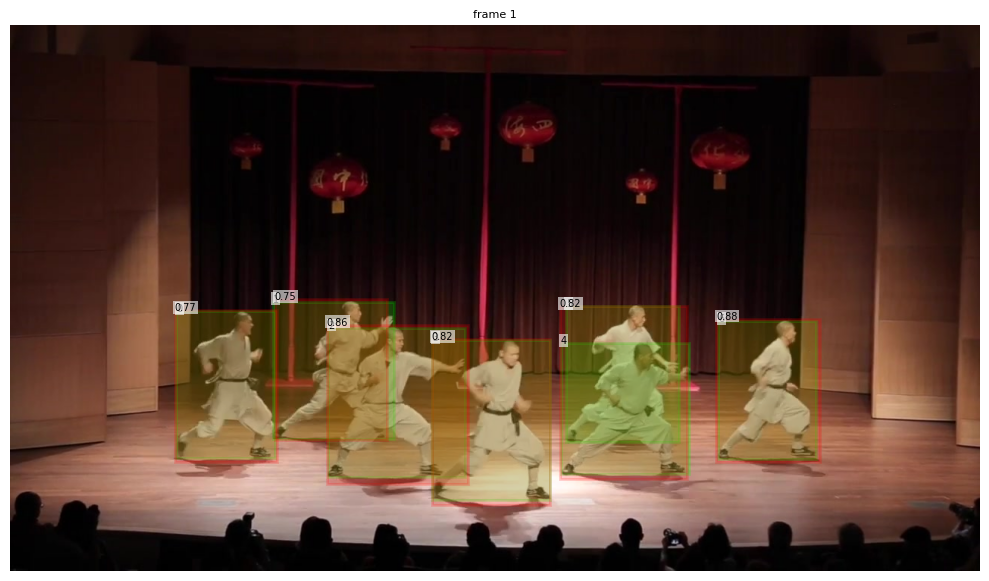

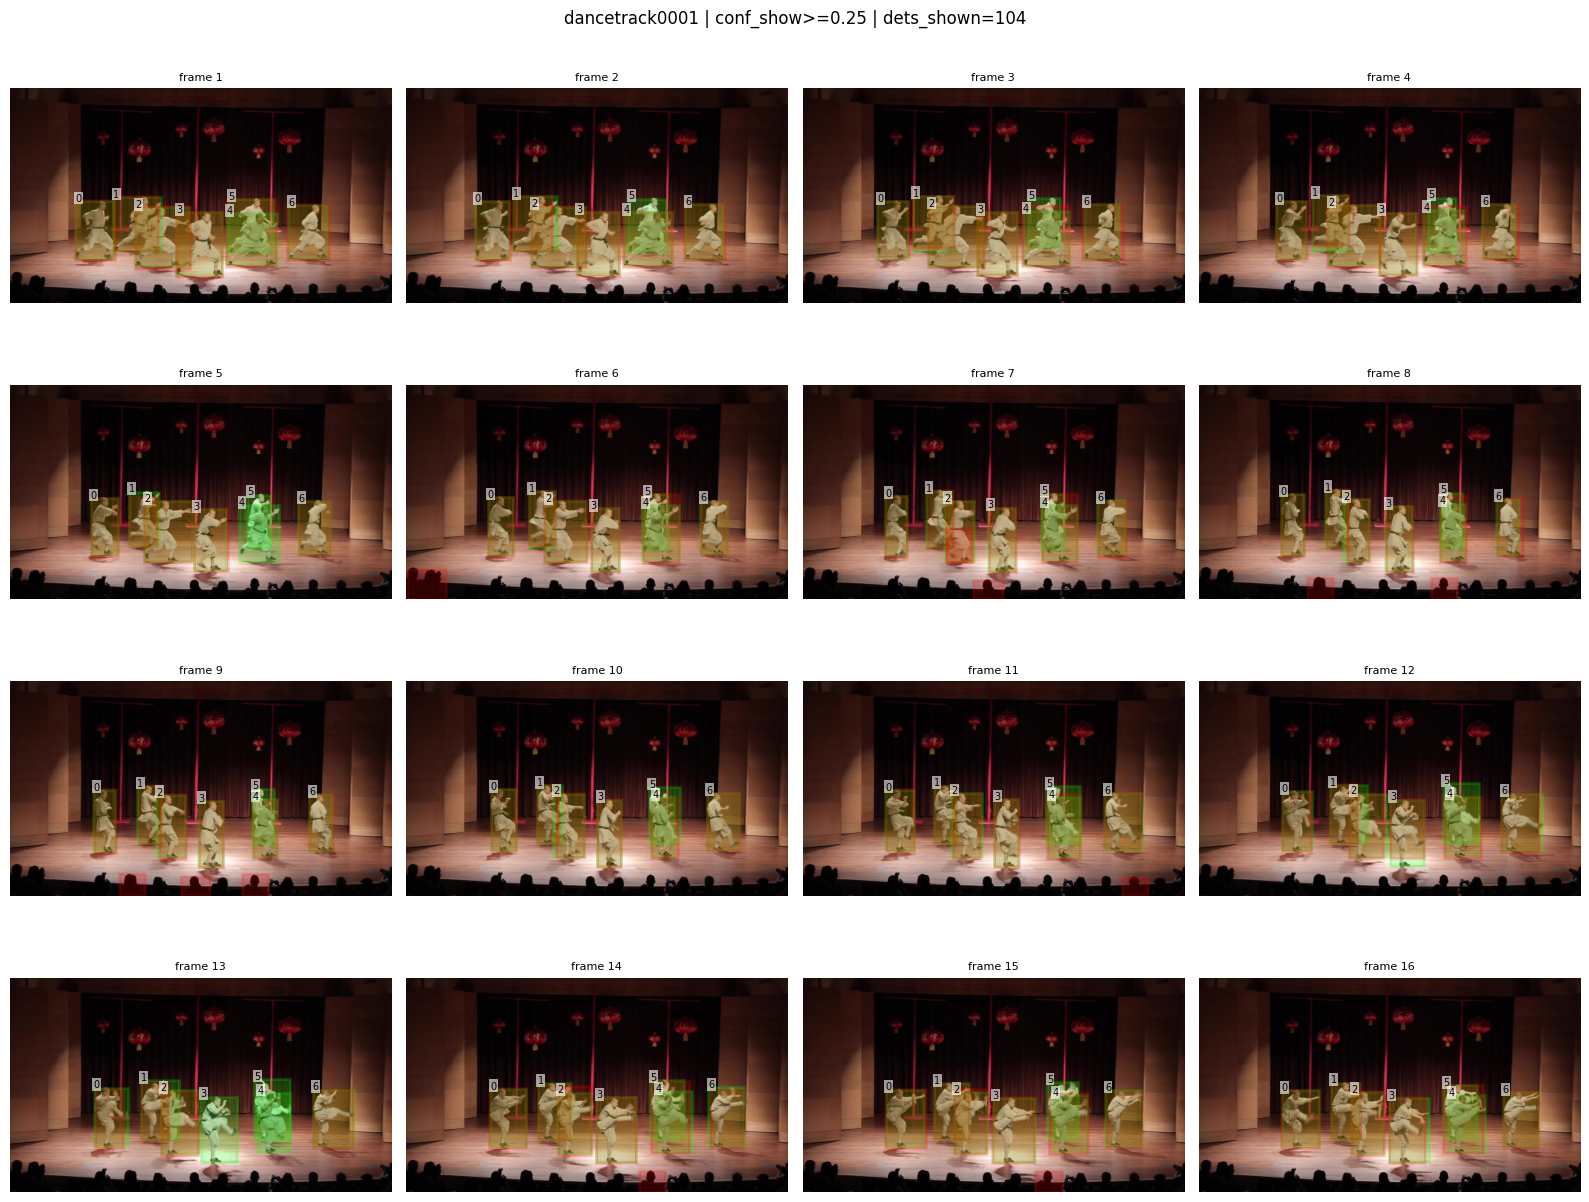

In [21]:
# --- Visualize ---
show_frame_gt_vs_yolo(ds, seqs[0], frame_index=0, det_fn=det_fn, conf_show=YOLO_CONFIDENCE)
show_sequence_grid_gt_vs_yolo(ds, seqs[0], start_frame_index=0, grid=4, det_fn=det_fn, conf_show=YOLO_CONFIDENCE)


In [22]:
# --- Use saved results to speed up ---
det_fn_cached = make_det_fn_from_mot(YOLO_ONLY_DIR, conf_thresh=YOLO_CONFIDENCE)

# --- Load embeddings model for Tracker B2 ---
reid_model = load_reid_backbone_resnet50(device=DEVICE, verbose=True)

[DET-CACHE] Using cached detections from: /content/drive/MyDrive/DANCE/results/outputs/YOLO_ONLY
[DET-CACHE] conf_thresh=0.25
[load_reid_backbone_resnet50] loaded ResNet50 feature extractor


In [23]:
# --- B0 tracker ---
base = make_config(model="B0")

cfg_b0_conservative = make_config(
    model="B0",
    iou_thresh=0.6,   # strict overlap requirement
    max_age=15,       # short survival
    min_hits=3
)

cfg_b0_balanced = make_config(
    model="B0",
    iou_thresh=0.3,   # moderate overlap
    max_age=30,       # standard survival
    min_hits=3
)


cfg_b0_permissive = make_config(
    model="B0",
    iou_thresh=0.2,   # permissive matching
    max_age=60,       # long survival
    min_hits=1
)

if not LOAD_IF_AVAILABLE:
  for name, cfg in {
      "B0_conservative": cfg_b0_conservative,
      "B0_balanced": cfg_b0_balanced,
      "B0_permissive": cfg_b0_permissive,
  }.items():
      print(f"\nRunning {name}")
      run_and_eval(
          seqs,
          SPLIT_DIR,
          SPLIT_DIR,
          Path(OUT_BASE, name),
          cfg,
          ds_full=ds,
          det_fn=det_fn_cached,
          reid_model=reid_model,
          max_frames=MAX_FRAMES,
          verbose=True,
          print_metrics=True,
          print_cfg=True
      )




In [24]:
cfg1 = make_config("B1")
cfg1.update(dict(
    high_thresh=0.60,
    low_thresh=0.10,
    iou_thresh_high=0.30,
    iou_thresh_low=0.20,
    max_age=30,
    min_hits=3,
))
cfg2 = make_config("B1")
cfg2.update(dict(
    high_thresh=0.70,
    low_thresh=0.10,
    iou_thresh_high=0.35,
    iou_thresh_low=0.25,
    max_age=30,
    min_hits=3,
))
cfg3 = make_config("B1")
cfg3.update(dict(
    high_thresh=0.50,
    low_thresh=0.05,
    iou_thresh_high=0.25,
    iou_thresh_low=0.15,
    max_age=30,
    min_hits=3,
))
cfg4 = make_config("B1")
cfg4.update(dict(
    high_thresh=0.60,
    low_thresh=0.10,
    iou_thresh_high=0.30,
    iou_thresh_low=0.20,
    max_age=60,
    min_hits=3,
))
cfg5 = make_config("B1")
cfg5.update(dict(
    high_thresh=0.65,
    low_thresh=0.10,
    iou_thresh_high=0.35,
    iou_thresh_low=0.20,
    max_age=15,
    min_hits=3,
))
candidates = [
    ("B1_balanced", cfg1),
    ("B1_conservative_ID", cfg2),
    ("B1_recall_recovery", cfg3),
    ("B1_long_occlusion", cfg4),
    ("B1_crowd_safe", cfg5),
]

if not LOAD_IF_AVAILABLE:
  for name, cfg in candidates:
      print("\n==============================")
      print(name)
      res, reid_model, runtime_stats = run_and_eval(
          seqs,
          SPLIT_DIR,
          SPLIT_DIR,
          Path(OUT_BASE, name),
          cfg,
          ds_full=ds,
          det_fn=det_fn_cached,
          reid_model=reid_model,
          max_frames=MAX_FRAMES,
          verbose=True,
          print_metrics=True,
          print_cfg=True
      )




In [25]:
b2_1 = make_config("B2")
b2_1.update(dict(
    high_thresh=0.60,
    low_thresh=0.10,
    iou_thresh_high=0.30,
    iou_thresh_low=0.20,
    reid_age=5,
    reid_cos_thresh=0.30,
    max_age=30,
    min_hits=3,
))
b2_2 = make_config("B2")
b2_2.update(dict(
    high_thresh=0.65,
    low_thresh=0.10,
    iou_thresh_high=0.35,
    iou_thresh_low=0.20,
    reid_age=5,
    reid_cos_thresh=0.22,   # stricter
    max_age=30,
    min_hits=3,
))
b2_3 = make_config("B2")
b2_3.update(dict(
    high_thresh=0.55,
    low_thresh=0.05,
    iou_thresh_high=0.25,
    iou_thresh_low=0.15,
    reid_age=8,
    reid_cos_thresh=0.38,   # more permissive
    max_age=45,
    min_hits=3,
))
b2_4 = make_config("B2")
b2_4.update(dict(
    high_thresh=0.60,
    low_thresh=0.10,
    iou_thresh_high=0.30,
    iou_thresh_low=0.20,
    reid_age=10,            # longer ReID window
    reid_cos_thresh=0.32,
    max_age=60,
    min_hits=3,
))
b2_5 = make_config("B2")
b2_5.update(dict(
    high_thresh=0.70,
    low_thresh=0.10,
    iou_thresh_high=0.35,
    iou_thresh_low=0.25,
    reid_age=3,
    reid_cos_thresh=0.25,
    max_age=20,
    min_hits=3,
))
b2_candidates = [
    ("B2_balanced", b2_1),
    ("B2_conservative", b2_2),
    ("B2_aggressive_recovery", b2_3),
    ("B2_long_occlusion", b2_4),
    ("B2_crowd_safe", b2_5),
]

if not LOAD_IF_AVAILABLE:
  for name, cfg in b2_candidates:
      print("\n==============================")
      print(name)
      res, reid_model, runtime_stats =run_and_eval(
          seqs,
          SPLIT_DIR,
          SPLIT_DIR,
          Path(OUT_BASE, name),
          cfg,
          ds_full=ds,
          det_fn=det_fn_cached,
          reid_model=reid_model,
          max_frames=MAX_FRAMES,
          verbose=True,
          print_metrics=True,
          print_cfg=True
      )



## 🔍Ablation study

### 🧬Effect of Appearance-Based Re-Identification

In [26]:
def select_dets(pred_frames, frame, max_people=12, score_thresh=0.25, sort_by_score=True):
    items = list(pred_frames.get(int(frame), []))
    items = [d for d in items if float(d.get("score", 0.0)) >= float(score_thresh)]
    if sort_by_score:
        items.sort(key=lambda d: float(d.get("score", 0.0)), reverse=True)
    items = items[:int(max_people)]
    return items

def build_id_index(pred_frames, frame):
    """Map id -> det dict for a given frame."""
    idx = {}
    for d in pred_frames.get(int(frame), []):
        if "id" in d and "xyxy" in d:
            idx[int(d["id"])] = d
    return idx

def cosine_sim_matrix_torch(E):
    """E: torch tensor [N,D] on any device. Returns numpy [N,N]."""
    E = F.normalize(E, dim=1)
    S = E @ E.T
    return S.detach().cpu().numpy()


def crop_viz(img_hwc_u8, xyxy, pad=0):
    x1, y1, x2, y2 = map(float, xyxy)
    H, W = img_hwc_u8.shape[:2]
    x1 = int(max(0, x1 - pad))
    y1 = int(max(0, y1 - pad))
    x2 = int(min(W, x2 + pad))
    y2 = int(min(H, y2 + pad))
    return img_hwc_u8[y1:y2, x1:x2].copy()

def reid_debug_similarity(
    ds,
    seq,
    frame,
    pred_frames,
    reid_model,
    device="cuda",
    max_people=12,
    score_thresh=0.25,
    sort_by_score=True,
    include_prev_next=True,          # <-- add same IDs from frame-1 and frame+1
    save_dir=None,
    save_prefix=None,
    show=True,
    dpi=200,
):
    """
    Builds similarity matrix for:
      - current frame top detections
      - optionally same IDs in prev/next frame (if present)

    Saves:
      <prefix>_crops.jpg
      <prefix>_sim.jpg
      <prefix>_matrix.npz  (S, labels, ids, frames)
    """
    frame = int(frame)
    prefix = save_prefix or f"{seq}_f{frame:06d}"

    # Load current frame
    img_chw_01, img_hwc_u8, fname = load_frame(ds, seq, frame)

    # Select detections in current frame
    cur_items = select_dets(
        pred_frames, frame,
        max_people=max_people,
        score_thresh=score_thresh,
        sort_by_score=sort_by_score
    )
    if len(cur_items) == 0:
        print(f"[reid_debug_similarity] No dets for {seq} frame {frame} at score_thresh={score_thresh}")
        return None

    # Build list of (label, frame_i, id, xyxy) for all rows/cols in the matrix
    entries = []
    for d in cur_items:
        tid = int(d["id"])
        entries.append((f"f{frame}:id{tid}", frame, tid, d["xyxy"]))

    if include_prev_next:
        cur_ids = [int(d["id"]) for d in cur_items]
        for f2 in [frame - 1, frame + 1]:
            idx = build_id_index(pred_frames, f2)
            for tid in cur_ids:
                if tid in idx:
                    d = idx[tid]
                    entries.append((f"f{f2}:id{tid}", f2, tid, d["xyxy"]))

    # Compute embeddings per frame (group to avoid re-loading frame repeatedly)
    # frames_to_entries: f -> list of (label, tid, xyxy)
    frames_to_entries = {}
    for label, f_i, tid, xyxy in entries:
        frames_to_entries.setdefault(f_i, []).append((label, tid, xyxy))

    all_labels = []
    all_frames = []
    all_ids = []
    all_embs = []

    for f_i, lst in frames_to_entries.items():
        img_chw_01_i, _, _ = load_frame(ds, seq, f_i)
        boxes = [list(map(float, e[2])) for e in lst]
        emb = extract_embeddings(img_chw_01_i, boxes, reid_model)  # [K,D]

        for k, (label, tid, _) in enumerate(lst):
            all_labels.append(label)
            all_frames.append(int(f_i))
            all_ids.append(int(tid))
            all_embs.append(emb[k:k+1])

    E = torch.cat(all_embs, dim=0)  # [N,D]
    S = cosine_sim_matrix_torch(E)  # [N,N] numpy

    # ---- Visualization crops: only current frame crops grid (keeps it readable)
    crops = [crop_viz(img_hwc_u8, d["xyxy"]) for d in cur_items]
    ids = [int(d["id"]) for d in cur_items]
    scores = [float(d.get("score", 0.0)) for d in cur_items]

    cols = min(6, len(crops))
    rows = int(np.ceil(len(crops) / cols))

    fig1 = plt.figure(figsize=(3 * cols, 3 * rows))
    for i, c in enumerate(crops):
        ax = fig1.add_subplot(rows, cols, i + 1)
        ax.imshow(c)
        ax.set_title(f"id {ids[i]} | conf={scores[i]:.2f}")
        ax.axis("off")
    fig1.suptitle(f"{seq} frame {frame} crops ({fname})")
    fig1.tight_layout()

    # ---- Similarity heatmap (all entries)
    fig2 = plt.figure(figsize=(max(7, 0.35 * len(all_labels)), max(6, 0.35 * len(all_labels))))
    ax2 = fig2.add_subplot(1, 1, 1)
    im = ax2.imshow(S, vmin=0, vmax=1)
    fig2.colorbar(im, ax=ax2, label="cosine similarity")
    ax2.set_xticks(range(len(all_labels)))
    ax2.set_yticks(range(len(all_labels)))
    ax2.set_xticklabels(all_labels, rotation=90, fontsize=8)
    ax2.set_yticklabels(all_labels, fontsize=8)
    ax2.set_title(f"ReID cosine similarity | {seq} frame {frame} (plus prev/next={include_prev_next})")
    fig2.tight_layout()

    # ---- Save
    if save_dir is not None:
        save_dir = Path(save_dir)
        save_dir.mkdir(parents=True, exist_ok=True)

        crops_path = save_dir / f"{prefix}_crops.jpg"
        sim_path   = save_dir / f"{prefix}_sim.jpg"
        npz_path   = save_dir / f"{prefix}_matrix.npz"

        fig1.savefig(crops_path, dpi=dpi, bbox_inches="tight")
        fig2.savefig(sim_path, dpi=dpi, bbox_inches="tight")

        np.savez_compressed(
            npz_path,
            S=S,
            labels=np.array(all_labels, dtype=object),
            frames=np.array(all_frames, dtype=np.int32),
            ids=np.array(all_ids, dtype=np.int32),
        )

        print("Saved:")
        print(" ", crops_path)
        print(" ", sim_path)
        print(" ", npz_path)

    if show:
        plt.show()
    else:
        plt.close(fig1)
        plt.close(fig2)

    return {
        "seq": seq,
        "frame": frame,
        "fname": fname,
        "cur_ids": ids,
        "labels": all_labels,
        "S": S,
    }


def run_reid_debug_batch(
    ds,
    cases,                 # [(seq, frame), ...]
    out_base,
    tracker_subdir,
    reid_model,
    device="cuda",
    save_dir="/content/reid_debug",
    max_people=12,
    score_thresh=0.25,
    sort_by_score=True,
    include_prev_next=True,
    show=False,
):
    """
    Loads pred file per sequence and runs reid_debug_similarity on each case.
    """
    from pathlib import Path

    out_base = Path(out_base)
    save_dir = Path(save_dir)
    save_dir.mkdir(parents=True, exist_ok=True)

    results = []
    for seq, frame in cases:
        pred_path = out_base / tracker_subdir / f"{seq}.txt"
        if not pred_path.exists():
            print(f"Missing prediction file: {pred_path}")
            results.append(None)
            continue

        pred_frames = parse_mot_txt(pred_path, is_gt=False)

        res = reid_debug_similarity(
            ds=ds,
            seq=seq,
            frame=int(frame),
            pred_frames=pred_frames,
            reid_model=reid_model,
            device=device,
            max_people=max_people,
            score_thresh=score_thresh,
            sort_by_score=sort_by_score,
            include_prev_next=include_prev_next,
            save_dir=save_dir,
            save_prefix=f"{seq}_f{int(frame):06d}",
            show=show,
        )
        results.append(res)

    return results

def load_frame(ds, seq, frame):
    """
    Returns:
      img_chw_01: torch.float32 CHW in 0..1 (CPU)
      img_hwc_u8: numpy uint8 HWC (for visualization)
      fname: str (if ds provides it, else "unknown")
    Works with ds.get_frame returning 2 or 3 values and tensors/arrays/PIL.
    Fixes your dataset layout: (W,C,H) -> (C,H,W).
    """
    ret = ds.get_frame(seq, frame)

    fname = "unknown"
    if not isinstance(ret, (tuple, list)):
        raise ValueError("ds.get_frame must return a tuple/list")

    if len(ret) == 3:
        a, b, fname = ret
    elif len(ret) == 2:
        a, b = ret
        # b might be filename sometimes
        if isinstance(b, (str, Path)):
            fname = str(b)
            b = None
    else:
        raise ValueError(f"ds.get_frame returned {len(ret)} values; expected 2 or 3")

    # choose the actual image tensor/array
    cand = []
    for x in (a, b):
        if x is None:
            continue
        if torch.is_tensor(x) and x.ndim == 3:
            cand.append(x)
        elif isinstance(x, np.ndarray) and x.ndim == 3:
            cand.append(torch.from_numpy(x))
    if not cand:
        raise ValueError("Could not find a 3D image tensor/array in ds.get_frame outputs")

    img = cand[-1].detach().cpu()  # pick the last 3D thing (usually the numeric image)

    # ---- canonicalize to CHW ----
    # Your case: (W,C,H) like (1920,3,1080)
    if img.shape[1] in (1, 3, 4) and img.shape[0] > 10 and img.shape[2] > 10 and img.shape[0] != 3:
        # W C H -> C H W (this yields (3,1080,1920) for your example)
        img = img.permute(1, 2, 0)
    # HWC -> CHW
    elif img.shape[-1] in (1, 3, 4) and img.shape[0] > 10 and img.shape[1] > 10:
        img = img.permute(2, 0, 1)
    # CHW already
    elif img.shape[0] in (1, 3, 4):
        pass
    else:
        raise ValueError(f"Unrecognized image layout from ds: {tuple(img.shape)}")

    # RGBA->RGB, Gray->RGB
    if img.shape[0] == 4:
        img = img[:3]
    if img.shape[0] == 1:
        img = img.repeat(3, 1, 1)
    if img.shape[0] != 3:
        raise ValueError(f"Expected 3 channels after canonicalize, got {tuple(img.shape)}")

    # float32 0..1
    img = img.to(torch.float32)
    if float(img.max().item()) > 1.5:
        img = (img / 255.0).clamp(0, 1)

    img_chw_01 = img.contiguous()  # CPU

    # make viz image HWC uint8
    img_hwc = (img_chw_01.permute(1, 2, 0).numpy() * 255.0).clip(0, 255).astype(np.uint8)

    return img_chw_01, img_hwc, fname


Saved:
  /content/reid_debug/dancetrack0029_f000121_crops.jpg
  /content/reid_debug/dancetrack0029_f000121_sim.jpg
  /content/reid_debug/dancetrack0029_f000121_matrix.npz


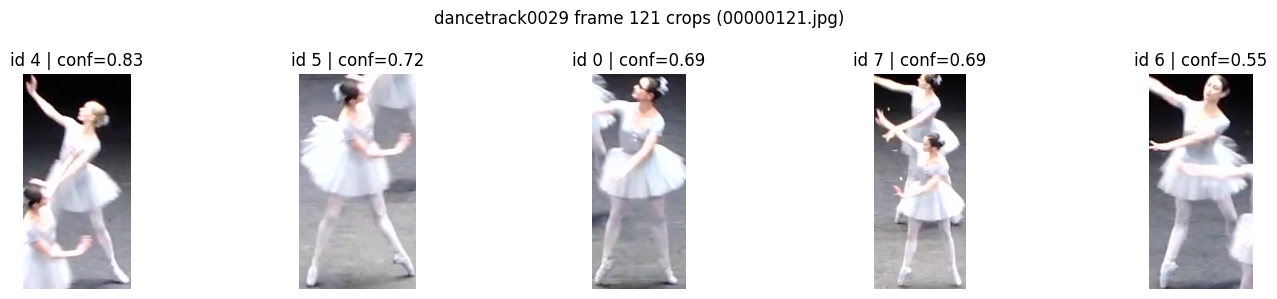

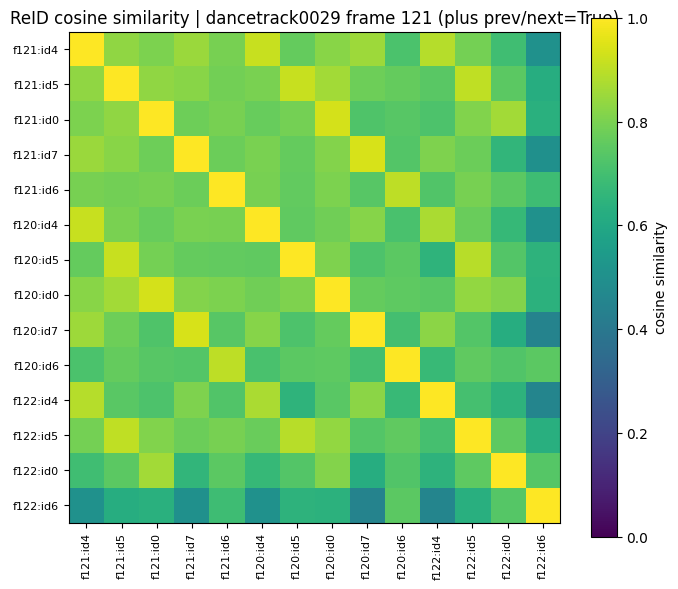

Saved:
  /content/reid_debug/dancetrack0001_f000200_crops.jpg
  /content/reid_debug/dancetrack0001_f000200_sim.jpg
  /content/reid_debug/dancetrack0001_f000200_matrix.npz


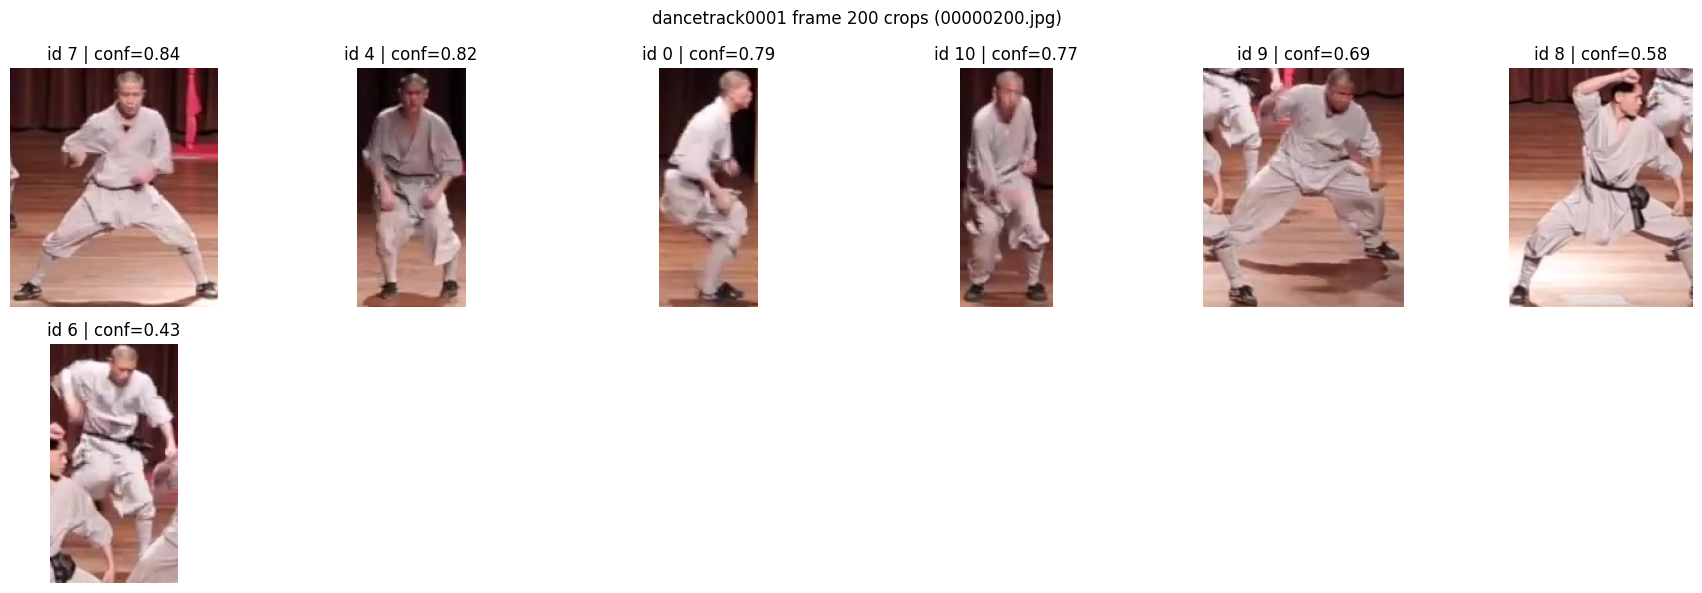

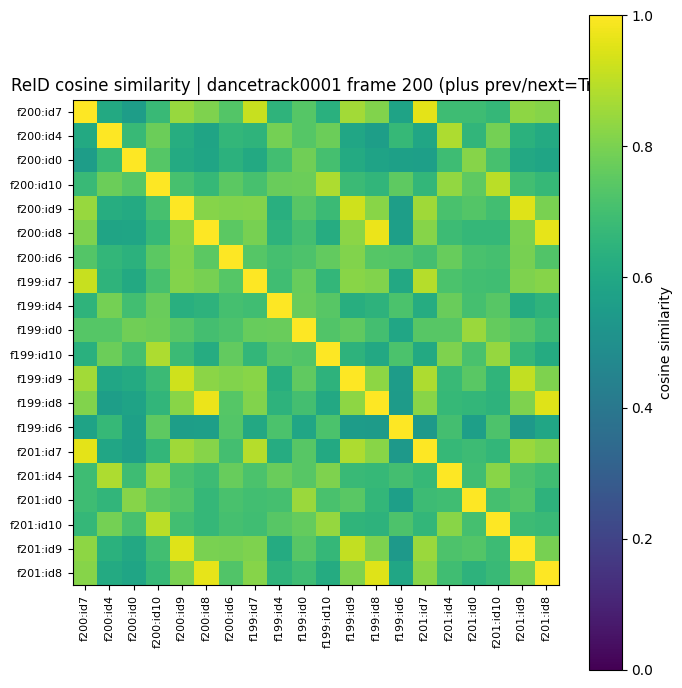

[reid_debug_similarity] No dets for dancetrack0083 frame 150 at score_thresh=0.25


In [27]:
cases = [
    ("dancetrack0029", 121),
    ("dancetrack0001", 200),
    ("dancetrack0083", 150),
]

results = run_reid_debug_batch(
    ds=ds,
    cases=cases,
    out_base=OUT_BASE,
    tracker_subdir="B2_conservative",
    reid_model=reid_model,
    save_dir="/content/reid_debug",
    max_people=12,
    score_thresh=0.25,
    include_prev_next=True,   # <-- adds same IDs from frame-1 and frame+1
    show=True
)


### 🎬 Qualitative Comparison via Parallel Visualization

In [28]:
_COLOR_CACHE = {}

def _id_color(tid):
    """Deterministic pseudo-color per track id (cached)."""
    tid = int(tid)
    if tid not in _COLOR_CACHE:
        rng = np.random.default_rng(abs(tid) % (2**32))
        _COLOR_CACHE[tid] = tuple(rng.random(3))
    return _COLOR_CACHE[tid]


def draw_tracks(ax, items, label, linewidth=2):
    """
    Draw bounding boxes where each box is colored by 'id' and annotated with the id.
    Items may store either 'box' (xywh) or 'xyxy'.
    """
    ax.set_title(label)
    for it in items:
        x, y, w, h = get_xywh(it)  # uses your existing helper
        tid = it["id"]
        c = _id_color(tid)

        rect = patches.Rectangle((x, y), w, h, fill=False, linewidth=linewidth, edgecolor=c)
        ax.add_patch(rect)
        ax.text(
            x, y, str(int(tid)),
            color=c, fontsize=9,
            bbox=dict(facecolor="black", alpha=0.3, pad=1, edgecolor="none")
        )

def count_unique_ids_from_mot(mot_path: Path, keep_negative: bool = False) -> int:
    """
    Count unique track IDs in a MOT txt file.
    By default, ignores negative IDs.
    """
    mot_path = Path(mot_path)
    if not mot_path.exists():
        raise FileNotFoundError(f"MOT file not found: {mot_path}")

    ids = set()
    with open(mot_path, "r") as f:
        for line in f:
            line = line.strip()
            if not line or line.startswith("#"):
                continue
            parts = line.split(",")
            if len(parts) < 2:
                continue
            tid = int(float(parts[1]))
            if keep_negative or tid >= 0:
                ids.add(tid)
    return len(ids)


def count_unique_ids_per_model(out_base_dir, seq: str, model_map: dict, keep_negative: bool = False) -> dict:
    """
    model_map: {display_label: subfolder_name_under_out_base}
    Returns: {display_label: unique_id_count}
    """
    out_base_dir = Path(out_base_dir)
    counts = {}
    for label, subdir in model_map.items():
        mot_path = out_base_dir / subdir / f"{seq}.txt"
        counts[label] = count_unique_ids_from_mot(mot_path, keep_negative=keep_negative)
    return counts


def make_parallel_tracks_video(
    ds_full,                      # your DanceTrackFrameDataset instance
    out_base_dir,                 # base folder containing model subfolders with {seq}.txt
    seq=None,                     # "dancetrack0001" OR None if using seq_idx
    seq_idx=None,                 # 0-based index into ds_full.seqs (if seq not given)
    fps=30,
    start_at=0,                   # index into the sequence ordering (not a frame_id)
    max_frames=None,              # number of frames to render
    image_ext=".jpg",             # kept for compatibility; dataset already indexed by ext
    model_map=None,               # {display_label: subfolder_name}
    out_path=None,                # final mp4 path
    dpi=140,
    debug=False,
    log_every=25,
    unique_ids_by_model=None,     # if None, will compute from MOT files automatically
):
    """
    Creates ONE MP4 video where each frame is a 2x3 grid showing the SAME video frame
    with track overlays from each model in parallel.

    Requires:
      - parse_mot_txt(path, is_gt=False) defined in your notebook
      - draw_tracks(ax, items, label=..., linewidth=...) defined in your notebook
      - ds_full is your DanceTrackFrameDataset (already sorts frames by real filenames)
    """
    import imageio.v2 as imageio
    import os

    def dbg(*args):
        if debug:
            print("[DEBUG]", *args)

    out_base_dir = Path(out_base_dir)

    # Resolve sequence names from dataset
    seqs = [p.name for p in ds_full.seqs]
    dbg("Found sequences:", len(seqs))

    if seq is None:
        assert seq_idx is not None, "Provide either seq='dancetrackXXXX' or seq_idx=<int>"
        assert 0 <= seq_idx < len(seqs), f"seq_idx out of range. Found {len(seqs)} sequences."
        seq = seqs[seq_idx]
        dbg("Resolved seq from idx:", seq_idx, "->", seq)
    else:
        assert seq in seqs, f"Sequence '{seq}' not found in dataset"
        dbg("Using provided seq:", seq)

    # Default five-model map
    if model_map is None:
        model_map = {
            "B0_balanced": "B0_balanced",
            "B1_long_occlusion": "B1_long_occlusion",
            "B2_conservative": "B2_conservative"
        }
    dbg("Model map:", model_map)

    # Load MOT predictions per model (once)
    pred_by_model = {}
    for label, subdir in model_map.items():
        mot_path = out_base_dir / subdir / f"{seq}.txt"
        dbg(f"MOT [{label}]:", mot_path, "exists:", mot_path.exists(),
            "size:", mot_path.stat().st_size if mot_path.exists() else None)
        if not mot_path.exists():
            raise FileNotFoundError(f"Missing MOT file for '{label}': {mot_path}")
        pred_by_model[label] = parse_mot_txt(mot_path, is_gt=False)

    # Unique ID counts (recommended computed from MOT outputs)
    if unique_ids_by_model is None:
        unique_ids_by_model = count_unique_ids_per_model(out_base_dir, seq, model_map)
        dbg("Unique IDs by model:", unique_ids_by_model)

    # Output path
    if out_path is None:
        out_dir = out_base_dir / "videos"
        out_dir.mkdir(parents=True, exist_ok=True)
        out_path = out_dir / f"{seq}_parallel.mp4"
    else:
        out_path = Path(out_path)
        out_path.parent.mkdir(parents=True, exist_ok=True)

    dbg("Output path:", out_path)
    dbg("Output dir exists:", out_path.parent.exists())
    dbg("Output dir writable:", os.access(out_path.parent, os.W_OK))

    labels = list(model_map.keys())

    # Use dataset’s precomputed chronological order for this sequence
    seq_indices = list(ds_full.seq_to_indices.get(seq, []))
    if len(seq_indices) == 0:
        raise RuntimeError(f"No frames indexed for sequence {seq}")

    assert 0 <= start_at < len(seq_indices), f"start_at out of range: {start_at} vs {len(seq_indices)}"

    end_at = len(seq_indices) if max_frames is None else min(len(seq_indices), start_at + max_frames)
    total_to_render = end_at - start_at
    dbg("Sequence frames indexed:", len(seq_indices))
    dbg("Rendering:", total_to_render, "frames from idx", start_at, "to", end_at - 1)


    nrows, ncols = 2, 2

    # Open video writer
    try:
        writer = imageio.get_writer(str(out_path), fps=int(fps))
        dbg("Opened imageio writer successfully")
    except Exception as e:
        raise RuntimeError(f"Failed to open imageio writer: {e}")

    written = 0

    for k in range(start_at, end_at):
        ds_idx = seq_indices[k]
        seq_name, frame_path, frame_id = ds_full.samples[ds_idx]
        assert seq_name == seq

        frame_path = Path(frame_path)
        if not frame_path.exists():
            writer.close()
            raise RuntimeError(f"Frame file missing: {frame_path}")

        if written == 0:
            dbg("First frame:", frame_path, "frame_id:", frame_id)

        img = plt.imread(str(frame_path))

        fig, axes = plt.subplots(nrows, ncols, figsize=(18, 10), dpi=dpi)
        axes = np.array(axes).reshape(-1)

        for ax in axes:
            ax.axis("off")

        # Draw each model in its panel
        for i, label in enumerate(labels):
            ax = axes[i]
            ax.imshow(img)
            items = pred_by_model[label].get(int(frame_id), [])
            draw_tracks(ax, items, label=label, linewidth=2)

        # Fill empty 6th panel with the raw image (optional)
        if len(labels) < len(axes):
            axes[len(labels)].imshow(img)
            axes[len(labels)].axis("off")

        # Subtitle with total unique IDs per model
        subtitle_lines = [f"{seq} — frame_id {frame_id}"]
        subtitle_lines.append(
            " | ".join(f"{lab}: {unique_ids_by_model.get(lab, 0)} IDs" for lab in labels)
        )
        fig.suptitle("\n".join(subtitle_lines), fontsize=14)

        # Convert matplotlib figure -> RGB array
        fig.canvas.draw()
        w, h = fig.canvas.get_width_height()
        frame = np.frombuffer(fig.canvas.buffer_rgba(), dtype=np.uint8).reshape(h, w, 4)[..., :3]

        try:
            writer.append_data(frame)
        except Exception as e:
            writer.close()
            plt.close(fig)
            raise RuntimeError(f"Failed to write frame_id={frame_id}: {e}")

        plt.close(fig)

        written += 1
        if debug and written % log_every == 0:
            dbg(f"Wrote {written}/{total_to_render} frames... last frame_id={frame_id}")

    writer.close()
    dbg("Writer closed")

    # Verify output
    exists = out_path.exists()
    size = out_path.stat().st_size if exists else None
    dbg("Final file exists:", exists, "size:", size)

    if written == 0:
        raise RuntimeError("No frames written. Check sequence indexing and dataset contents.")

    if not exists or (size is None) or size < 10_000:
        raise RuntimeError(
            f"Video file not created correctly: exists={exists}, size={size}. "
            "If you're writing to Google Drive, write to /content first then copy."
        )

    print(f"[VIDEO OK] {out_path} | frames={written} | fps={fps}")
    return out_path

# ds = DanceTrackFrameDataset(SPLIT_DIR_RESOLVED)
make_parallel_tracks_video(
    ds_full=ds,
    out_base_dir=OUT_BASE,
    seq="dancetrack0001",
    fps=30,
    start_at=0,
    max_frames=300,
    out_path="/content/drive/MyDrive/DANCE/results/train1_runs/videos/dancetrack0001_results.mp4",
    debug=True,
)


[DEBUG] Found sequences: 40
[DEBUG] Using provided seq: dancetrack0001
[DEBUG] Model map: {'B0_balanced': 'B0_balanced', 'B1_long_occlusion': 'B1_long_occlusion', 'B2_conservative': 'B2_conservative'}
[DEBUG] MOT [B0_balanced]: /content/drive/MyDrive/DANCE/results/train_runs/B0_balanced/dancetrack0001.txt exists: True size: 339159
[DEBUG] MOT [B1_long_occlusion]: /content/drive/MyDrive/DANCE/results/train_runs/B1_long_occlusion/dancetrack0001.txt exists: True size: 275772
[DEBUG] MOT [B2_conservative]: /content/drive/MyDrive/DANCE/results/train_runs/B2_conservative/dancetrack0001.txt exists: True size: 253280
[DEBUG] Unique IDs by model: {'B0_balanced': 112, 'B1_long_occlusion': 17, 'B2_conservative': 19}
[DEBUG] Output path: /content/drive/MyDrive/DANCE/results/train1_runs/videos/dancetrack0001_parallel.mp4
[DEBUG] Output dir exists: True
[DEBUG] Output dir writable: True
[DEBUG] Sequence frames indexed: 703
[DEBUG] Rendering: 300 frames from idx 0 to 299
[DEBUG] Opened imageio writer

[DEBUG] Wrote 25/300 frames... last frame_id=25
[DEBUG] Wrote 50/300 frames... last frame_id=50
[DEBUG] Wrote 75/300 frames... last frame_id=75
[DEBUG] Wrote 100/300 frames... last frame_id=100
[DEBUG] Wrote 125/300 frames... last frame_id=125
[DEBUG] Wrote 150/300 frames... last frame_id=150
[DEBUG] Wrote 175/300 frames... last frame_id=175
[DEBUG] Wrote 200/300 frames... last frame_id=200
[DEBUG] Wrote 225/300 frames... last frame_id=225
[DEBUG] Wrote 250/300 frames... last frame_id=250
[DEBUG] Wrote 275/300 frames... last frame_id=275
[DEBUG] Wrote 300/300 frames... last frame_id=300
[DEBUG] Writer closed
[DEBUG] Final file exists: True size: 5750412
[VIDEO OK] /content/drive/MyDrive/DANCE/results/train1_runs/videos/dancetrack0001_parallel.mp4 | frames=300 | fps=30


PosixPath('/content/drive/MyDrive/DANCE/results/train1_runs/videos/dancetrack0001_parallel.mp4')